## Import Packages

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom as dicom
import math

### 2 Voxels Patient Model (Xio)

#### **Cost Functions and Objectives**

*objective for the target*: $$ O_{T}(D_{T}) = (D_{T}-D_{GT})^{2} $$ 
*objective for the OAR*: $$ O_{N}(D_{N}) = (D_{N}-D_{GN})^{2} $$ 

$$ D_{GN} = 0 Gy, D_{GT} = 64 Gy $$
$$ F(D_{T},D_{N})=(D_{T})^{2}+(D_{N})^2 $$

In [2]:
## Target and Normal tissue Goals ##
D_g = np.array([[64], [0]])

T = np.array([[16,16,16,16],[15,0,17,0]])
weight_init = np.ones([4,1])
# calculate dose
D_c = np.dot(T,weight_init)
                        
# calculate gradient
G_OB = 2*np.dot((D_c-D_g).T,(np.dot(T,np.eye(4))))

# Normalize gradient
G_OB_N_init = (G_OB/np.sqrt(np.sum(G_OB*G_OB))).T

# weight -= i*G_OB_N.T
## Part 1: Physical Optimization ##
iteration = 18
OBJ_plot,D_matrix = [],[[],[]]

In [109]:
import tabletext

data = [['Voxel','Beamlet1','Beamlet2','Beamlet3','Beamlet4'],
        ['T',16,16,16,16],
        ['N',15,'-',17,'-'],
        ]

print (tabletext.to_text(data))

┌───────┬──────────┬──────────┬──────────┬──────────┐
│ Voxel │ Beamlet1 │ Beamlet2 │ Beamlet3 │ Beamlet4 │
├───────┼──────────┼──────────┼──────────┼──────────┤
│ T     │       16 │       16 │       16 │       16 │
├───────┼──────────┼──────────┼──────────┼──────────┤
│ N     │       15 │ -        │       17 │ -        │
└───────┴──────────┴──────────┴──────────┴──────────┘


#### **Gradient Descent for Line Search**

Dose Distribution: $$ D_{i} = T_{ij}W_{j}$$

Gradient Descent: $$ W_{i+1} = W_{i} - \lambda\frac{\partial{F}}{\partial{W_{i}}}$$

In [4]:
for j in range(iteration):
    
    L = np.arange(0,1.5*(2/3)**math.log(j+1),0.05/(j+1))
    weight_mat = np.zeros([weight_init.shape[0],len(L)])
    D_c_mat = np.zeros([D_g.shape[0],len(L)])
    OBJ_mat = np.zeros([1,len(L)])
    G_OB_mat = np.zeros([G_OB_N_init.shape[0],len(L)])
    weight = weight_init
    G_OB_N = G_OB_N_init
    for i in range(len(L)):
        
        # update weights
        weight_ = weight - L[i]*G_OB_N

        # calculate dose
        D_c_ = np.dot(T,weight_)
                                
        # calculate gradient
        G_OB_ = 2*np.dot((D_c_-D_g).T,(np.dot(T,np.eye(4))))

        # Normalize gradient
        G_OB_N_ = G_OB_/np.sqrt(np.sum(G_OB_*G_OB_))

        # calculate object
        OBJ_mat[:,i] = np.sum((D_c_-D_g)*(D_c_-D_g))
        D_c_mat[:,i] = np.reshape(D_c_,[D_c.shape[0],])
        weight_mat[:,i] = np.reshape(weight_,[weight.shape[0],])
        G_OB_mat[:,i] = np.reshape(G_OB_N_,[G_OB_N.shape[0],])
    # To find the minimal OBJ index
    min_index = np.where(OBJ_mat== np.min(OBJ_mat))
    print('minimum OBJ ={}'.format(OBJ_mat[min_index]))
    print('{}th iter, the Dose matrix:{}'.format(j,D_c_mat[:,min_index[1]]))
    print('{}th iter, the Gradient:{}'.format(j,G_OB_mat[:,min_index[1]]))
    OBJ_plot.append(OBJ_mat[min_index][0])
    D_matrix[0].append(D_c_mat[:,min_index[1]][0][0])
    D_matrix[1].append(D_c_mat[:,min_index[1]][1][0])
    # Update the weights
    weight_init = np.reshape(weight_mat[:,min_index[1]],[weight.shape[0],1])
    G_OB_N_init = np.reshape(G_OB_mat[:,min_index[1]],[G_OB_N.shape[0],1])
    


minimum OBJ =[510.07756246]
0th iter, the Dose matrix:[[48.19165368]
 [16.12990233]]
0th iter, the Gradient:[[-0.03064137]
 [-0.70552798]
 [ 0.05934352]
 [-0.70552798]]
minimum OBJ =[247.53847208]
1th iter, the Dose matrix:[[64.22695782]
 [15.73171835]]
1th iter, the Gradient:[[0.6622186 ]
 [0.01003614]
 [0.74917626]
 [0.01003614]]
minimum OBJ =[121.47311207]
2th iter, the Dose matrix:[[56.21074177]
 [ 7.79747192]]
2th iter, the Gradient:[[-0.04341023]
 [-0.70572646]
 [ 0.0448986 ]
 [-0.70572646]]
minimum OBJ =[60.20146872]
3th iter, the Dose matrix:[[64.10654328]
 [ 7.758229  ]]
3th iter, the Gradient:[[0.66219331]
 [0.00956008]
 [0.74921107]
 [0.00956008]]
minimum OBJ =[29.56677984]
4th iter, the Dose matrix:[[60.21551654]
 [ 3.90441606]]
4th iter, the Gradient:[[-0.02312645]
 [-0.70528876]
 [ 0.06782852]
 [-0.70528876]]
minimum OBJ =[14.16147717]
5th iter, the Dose matrix:[[64.22208451]
 [ 3.75661492]]
5th iter, the Gradient:[[0.66319516]
 [0.03933998]
 [0.74637585]
 [0.03933998]]
m

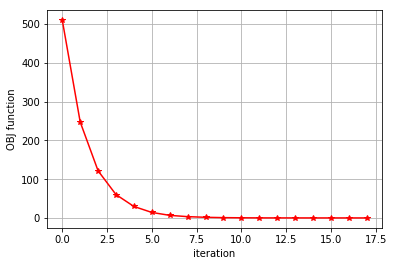

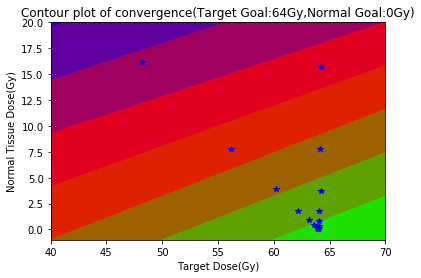

In [6]:
plt.figure(1)
plt.plot(OBJ_plot,'r-*')
plt.xlabel('iteration')
plt.ylabel('OBJ function')
plt.grid()
plt.show()

plt.figure(2)
x=np.array([40,70])
y=np.array([-1,20])
z=np.array([[40,70],[-1,20]])
plt.xlim(40,70)
plt.ylim(-1.0,20)
plt.contourf(x,y,z,cmap='brg')
plt.plot(D_matrix[0],D_matrix[1],'b*')
plt.title('Contour plot of convergence(Target Goal:64Gy,Normal Goal:0Gy)')
plt.xlabel('Target Dose(Gy)')
plt.ylabel('Normal Tissue Dose(Gy)')
plt.show()

### 25 Voxels Patient Model

In [20]:
import random

In [15]:
## Target and Normal tissue Goals ##
D_g = np.array([5,5,5,5,5,
               5,60,60,60,5,
               5,60,60,60,5,
               5,5,5,5,5,
               5,5,5,5,5])
weight_init = np.ones([20,1])
D_g = np.reshape(D_g,[D_g.shape[0],1])

In [16]:
D_g.shape

(25, 1)

In [17]:
weight_init.shape

(20, 1)

In [99]:
random.seed(2)
T = np.random.randint(0,2,size=(D_g.shape[0],weight_init.shape[0]))
T[6:9,:] += 1
T[11:14,:] +=1
T

array([[0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
       [0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
       [2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2],
       [1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1],
       [2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1],
       [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1],
       [1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2],
       [1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1,

In [95]:
# calculate dose
D_c = np.dot(T,weight_init)
D_c.shape

(25, 1)

In [96]:
# calculate gradient
G_OB = 2*np.dot((D_c-D_g).T,T)
# Normalize gradient
G_OB_N_init = (G_OB/np.sqrt(np.sum(G_OB*G_OB))).T
G_OB_N_init.shape

(20, 1)

In [100]:
## Part 1: Physical Optimization ##
iteration = 1000
OBJ_plot,D_matrix = [],[[],[]]
for j in range(iteration):
    
    L = np.arange(0,1.5*(2/3)**math.log(j+1),0.05/(j+1))
    weight_mat = np.zeros([weight_init.shape[0],len(L)])
    D_c_mat = np.zeros([D_g.shape[0],len(L)])
    OBJ_mat = np.zeros([1,len(L)])
    G_OB_mat = np.zeros([G_OB_N_init.shape[0],len(L)])
    weight = weight_init
    G_OB_N = G_OB_N_init
    for i in range(len(L)):
        
        # update weights
        weight_ = weight - L[i]*G_OB_N

        # calculate dose
        D_c_ = np.dot(T,weight_)
                                
        # calculate gradient
        G_OB_ = 2*np.dot((D_c_-D_g).T,T)

        # Normalize gradient
        G_OB_N_ = G_OB_/np.sqrt(np.sum(G_OB_*G_OB_))

        # calculate object
        OBJ_mat[:,i] = np.sum((D_c_-D_g)*(D_c_-D_g))
        D_c_mat[:,i] = np.reshape(D_c_,[D_c.shape[0],])
        weight_mat[:,i] = np.reshape(weight_,[weight.shape[0],])
        G_OB_mat[:,i] = np.reshape(G_OB_N_,[G_OB_N.shape[0],])
    # To find the minimal OBJ index
    min_index = np.where(OBJ_mat== np.min(OBJ_mat))
    print('minimum OBJ ={}'.format(OBJ_mat[min_index]))
    print('{}th iter, the Dose matrix:{}'.format(j,D_c_mat[:,min_index[1]]))
    print('{}th iter, the Gradient:{}'.format(j,G_OB_mat[:,min_index[1]]))
    OBJ_plot.append(OBJ_mat[min_index][0])
    D_matrix[0].append(D_c_mat[:,min_index[1]][0][0])
    D_matrix[1].append(D_c_mat[:,min_index[1]][1][0])
    # Update the weights
    weight_init = np.reshape(weight_mat[:,min_index[1]],[weight.shape[0],1])
    G_OB_N_init = np.reshape(G_OB_mat[:,min_index[1]],[G_OB_N.shape[0],1])
    


minimum OBJ =[82743.59739973]
0th iter, the Dose matrix:[[ 61.35871888]
 [-56.08360444]
 [-25.47472629]
 [126.56827766]
 [ 45.25170923]
 [120.24940629]
 [ 32.60832061]
 [ 81.68393705]
 [ 74.81204912]
 [114.68856497]
 [-10.2396924 ]
 [101.38153233]
 [ 29.97392925]
 [ 12.57530448]
 [ 47.61111188]
 [-16.01729518]
 [ 15.29670975]
 [ 17.23636854]
 [ 30.34789953]
 [-47.69423463]
 [ 95.99397241]
 [ 22.6612325 ]
 [  3.10687356]
 [115.06862688]
 [  9.0238861 ]]
0th iter, the Gradient:[[ 0.11434361]
 [ 0.34811037]
 [ 0.0267318 ]
 [ 0.16528924]
 [ 0.04413895]
 [ 0.34080575]
 [ 0.11190041]
 [ 0.25656037]
 [ 0.24131976]
 [ 0.47997039]
 [ 0.27811972]
 [ 0.05374927]
 [ 0.22392853]
 [ 0.10029596]
 [ 0.22865094]
 [ 0.21572725]
 [ 0.24779604]
 [ 0.2055791 ]
 [-0.06147056]
 [ 0.07716509]]
minimum OBJ =[79828.33010344]
1th iter, the Dose matrix:[[ 58.41109915]
 [-58.00797282]
 [-27.67164117]
 [124.2655878 ]
 [ 41.70909117]
 [117.18671332]
 [ 26.2875    ]
 [ 74.4249626 ]
 [ 68.0032737 ]
 [111.27872534]
 [-

minimum OBJ =[62865.14267527]
22th iter, the Dose matrix:[[ 45.55552716]
 [-56.88086233]
 [-31.97232821]
 [109.46364773]
 [ 30.574155  ]
 [102.47564879]
 [ 20.55136083]
 [ 55.73915559]
 [ 55.19882271]
 [ 91.43945512]
 [-13.11241274]
 [ 76.09965211]
 [ 14.55438894]
 [ -8.25176976]
 [ 35.00664372]
 [-19.03106548]
 [ 12.87292423]
 [  4.62138239]
 [ 15.83834498]
 [-39.64407606]
 [ 77.74589747]
 [ 13.91990657]
 [  7.64192841]
 [102.69847932]
 [  3.63082118]]
22th iter, the Gradient:[[-0.06528598]
 [ 0.30277186]
 [-0.27741987]
 [-0.10962313]
 [-0.23985464]
 [ 0.28187623]
 [-0.11843291]
 [ 0.05378855]
 [-0.0254092 ]
 [ 0.515852  ]
 [ 0.25675493]
 [-0.20057218]
 [ 0.09408152]
 [-0.152455  ]
 [ 0.03171116]
 [-0.03860958]
 [ 0.06327123]
 [-0.03202701]
 [-0.45180236]
 [-0.21104073]]
minimum OBJ =[62364.59585097]
23th iter, the Dose matrix:[[ 45.30854289]
 [-56.65745392]
 [-31.93806783]
 [109.06486041]
 [ 30.46233674]
 [102.14864647]
 [ 20.88480923]
 [ 55.65844608]
 [ 55.28888643]
 [ 90.95687032]


minimum OBJ =[56686.26556938]
36th iter, the Dose matrix:[[ 42.42770357]
 [-54.0332561 ]
 [-31.49629386]
 [104.32190268]
 [ 29.23134718]
 [ 98.23640659]
 [ 24.69743943]
 [ 54.76434997]
 [ 56.2399267 ]
 [ 85.34396814]
 [-12.5343814 ]
 [ 76.02526135]
 [ 15.95732765]
 [ -6.89918022]
 [ 32.2356383 ]
 [-18.15945815]
 [ 14.29529353]
 [  3.32708786]
 [ 13.32370802]
 [-33.37158753]
 [ 73.09420478]
 [ 14.19727092]
 [ 11.65379425]
 [ 99.47796613]
 [  4.51763365]]
36th iter, the Gradient:[[-0.05203514]
 [ 0.29632403]
 [-0.28226289]
 [-0.11151919]
 [-0.22647639]
 [ 0.28637615]
 [-0.11442044]
 [ 0.05714386]
 [-0.04297992]
 [ 0.51505251]
 [ 0.27299351]
 [-0.20044145]
 [ 0.10437481]
 [-0.16495165]
 [ 0.0177947 ]
 [-0.04664857]
 [ 0.06616238]
 [-0.03919532]
 [-0.44419385]
 [-0.20510692]]
minimum OBJ =[56300.94811277]
37th iter, the Dose matrix:[[ 42.22652109]
 [-53.84902188]
 [-31.46262226]
 [103.98445389]
 [ 29.15035721]
 [ 97.95639214]
 [ 24.95753996]
 [ 54.70484482]
 [ 56.29888786]
 [ 84.95333057]


minimum OBJ =[52082.75875744]
49th iter, the Dose matrix:[[ 39.97235288]
 [-51.77670703]
 [-31.05933621]
 [100.14716392]
 [ 28.28792485]
 [ 94.75685421]
 [ 27.81219707]
 [ 54.06446253]
 [ 56.89040793]
 [ 80.5900108 ]
 [-12.07987934]
 [ 76.03128577]
 [ 17.17182193]
 [ -5.70189029]
 [ 30.1926628 ]
 [-17.44914192]
 [ 15.30183272]
 [  2.42438491]
 [ 11.43728102]
 [-28.53902882]
 [ 69.42006712]
 [ 14.36349536]
 [ 14.66451616]
 [ 96.87461809]
 [  5.17479865]]
49th iter, the Gradient:[[-0.04142224]
 [ 0.29109013]
 [-0.28551069]
 [-0.11274687]
 [-0.21526988]
 [ 0.2893347 ]
 [-0.11060947]
 [ 0.06004812]
 [-0.05757579]
 [ 0.51381687]
 [ 0.28599154]
 [-0.20020282]
 [ 0.11346854]
 [-0.17477322]
 [ 0.00559626]
 [-0.05299875]
 [ 0.06860499]
 [-0.04521572]
 [-0.43753958]
 [-0.19944563]]
minimum OBJ =[51760.74609761]
50th iter, the Dose matrix:[[ 39.79621709]
 [-51.61414921]
 [-31.02575951]
 [ 99.84292626]
 [ 28.22405665]
 [ 94.50198848]
 [ 28.03052791]
 [ 54.01651599]
 [ 56.93124409]
 [ 80.25017384]


minimum OBJ =[48740.95740789]
60th iter, the Dose matrix:[[ 38.11467567]
 [-50.05746207]
 [-30.689487  ]
 [ 96.90579044]
 [ 27.64043743]
 [ 92.03267276]
 [ 30.07920175]
 [ 53.57472783]
 [ 57.28148872]
 [ 77.01443451]
 [-11.73581272]
 [ 76.0689654 ]
 [ 18.15770317]
 [ -4.71439137]
 [ 28.72856468]
 [-16.89623826]
 [ 15.99760731]
 [  1.81315061]
 [ 10.06576107]
 [-24.94460595]
 [ 66.63201039]
 [ 14.45524165]
 [ 16.85065972]
 [ 94.85336036]
 [  5.64801577]]
60th iter, the Gradient:[[-0.03334303]
 [ 0.28702138]
 [-0.28759418]
 [-0.11353631]
 [-0.20640291]
 [ 0.29112178]
 [-0.10733868]
 [ 0.06237592]
 [-0.06913718]
 [ 0.51243452]
 [ 0.29587851]
 [-0.19996015]
 [ 0.12095131]
 [-0.18219179]
 [-0.00448183]
 [-0.05784997]
 [ 0.07051026]
 [-0.05005349]
 [-0.43212274]
 [-0.19453927]]
minimum OBJ =[48457.50506754]
61th iter, the Dose matrix:[[ 37.95399159]
 [-49.90824731]
 [-30.65583162]
 [ 96.62200908]
 [ 27.5871632 ]
 [ 91.79325243]
 [ 30.27152866]
 [ 53.53405731]
 [ 57.31119145]
 [ 76.70608112]


minimum OBJ =[45520.92752576]
72th iter, the Dose matrix:[[ 36.25898382]
 [-48.32913163]
 [-30.28402179]
 [ 93.59495831]
 [ 27.05204057]
 [ 89.23033367]
 [ 32.26272806]
 [ 53.12211542]
 [ 57.5843451 ]
 [ 73.46288584]
 [-11.39175211]
 [ 76.13244286]
 [ 19.2018237 ]
 [ -3.6543519 ]
 [ 27.33918772]
 [-16.33002985]
 [ 16.63580162]
 [  1.26884153]
 [  8.74724824]
 [-21.41248217]
 [ 63.84363706]
 [ 14.51514037]
 [ 18.94801234]
 [ 92.78330135]
 [  6.09979876]]
72th iter, the Gradient:[[-0.02526843]
 [ 0.28288706]
 [-0.28929131]
 [-0.11418646]
 [-0.1972071 ]
 [ 0.29245463]
 [-0.10371694]
 [ 0.0648245 ]
 [-0.08113759]
 [ 0.51062796]
 [ 0.30574439]
 [-0.19965708]
 [ 0.12897539]
 [-0.18955415]
 [-0.01533326]
 [-0.06272565]
 [ 0.07245617]
 [-0.05514223]
 [-0.42637667]
 [-0.18904807]]
minimum OBJ =[45269.53264766]
73th iter, the Dose matrix:[[ 36.11122954]
 [-48.19102814]
 [-30.25012585]
 [ 93.32816664]
 [ 27.00773439]
 [ 89.0036601 ]
 [ 32.43299372]
 [ 53.08771841]
 [ 57.60467266]
 [ 73.18102848]


minimum OBJ =[40895.48737653]
92th iter, the Dose matrix:[[ 33.46890648]
 [-45.70833122]
 [-29.60173579]
 [ 88.476784  ]
 [ 26.27963739]
 [ 84.85981576]
 [ 35.38511577]
 [ 52.51564281]
 [ 57.87379088]
 [ 68.16536232]
 [-10.87318467]
 [ 76.2697648 ]
 [ 20.88636689]
 [ -1.9147276 ]
 [ 25.39376977]
 [-15.45133479]
 [ 17.48846484]
 [  0.58498178]
 [  6.86963839]
 [-16.22331865]
 [ 59.65382403]
 [ 14.54008967]
 [ 21.9222143 ]
 [ 89.55980298]
 [  6.73923766]]
92th iter, the Gradient:[[-0.01321128]
 [ 0.27660456]
 [-0.29097494]
 [-0.11486074]
 [-0.18273719]
 [ 0.29346712]
 [-0.09756536]
 [ 0.068767  ]
 [-0.10003048]
 [ 0.50702721]
 [ 0.32042127]
 [-0.19906815]
 [ 0.1421341 ]
 [-0.2004432 ]
 [-0.03323088]
 [-0.07008751]
 [ 0.0754457 ]
 [-0.0632983 ]
 [-0.41710196]
 [-0.17956262]]
minimum OBJ =[40684.34865158]
93th iter, the Dose matrix:[[ 33.33778136]
 [-45.58446093]
 [-29.56740878]
 [ 88.2320393 ]
 [ 26.2466991 ]
 [ 84.64966861]
 [ 35.52693342]
 [ 52.48944839]
 [ 57.88249401]
 [ 67.91774561]


minimum OBJ =[37146.77081733]
111th iter, the Dose matrix:[[ 31.08788807]
 [-43.44841845]
 [-28.94491663]
 [ 83.97299034]
 [ 25.72906391]
 [ 80.97592416]
 [ 37.88868694]
 [ 52.07420334]
 [ 57.96371309]
 [ 63.68956878]
 [-10.42858736]
 [ 76.41790739]
 [ 22.43577672]
 [ -0.28329477]
 [ 23.87589021]
 [-14.67406607]
 [ 18.11533711]
 [  0.14009666]
 [  5.37566484]
 [-11.92331956]
 [ 56.09112761]
 [ 14.49349283]
 [ 24.27128726]
 [ 86.68502455]
 [  7.2467572 ]]
111th iter, the Gradient:[[-0.00311087]
 [ 0.27126746]
 [-0.29141456]
 [-0.11509969]
 [-0.16977153]
 [ 0.29322895]
 [-0.09161159]
 [ 0.07241689]
 [-0.11695164]
 [ 0.50302421]
 [ 0.33262392]
 [-0.19841404]
 [ 0.15446118]
 [-0.20945766]
 [-0.05011663]
 [-0.07637357]
 [ 0.0780338 ]
 [-0.07076086]
 [-0.40858937]
 [-0.17016629]]
minimum OBJ =[36963.73943755]
112th iter, the Dose matrix:[[ 30.96865645]
 [-43.33463471]
 [-28.91011116]
 [ 83.74412243]
 [ 25.70414793]
 [ 80.77761115]
 [ 38.01000092]
 [ 52.05405331]
 [ 57.96444404]
 [ 63.4666255

minimum OBJ =[35372.46647772]
121th iter, the Dose matrix:[[ 2.99197151e+01]
 [-4.23309147e+01]
 [-2.85957159e+01]
 [ 8.17168422e+01]
 [ 2.54958994e+01]
 [ 7.90169735e+01]
 [ 3.90601692e+01]
 [ 5.18851490e+01]
 [ 5.79555211e+01]
 [ 6.15104357e+01]
 [-1.02094114e+01]
 [ 7.64976808e+01]
 [ 2.32343631e+01]
 [ 5.69356307e-01]
 [ 2.31808543e+01]
 [-1.42830410e+01]
 [ 1.83894070e+01]
 [-2.79069733e-02]
 [ 4.68208199e+00]
 [-9.86118731e+00]
 [ 5.43511048e+01]
 [ 1.44457828e+01]
 [ 2.53538425e+01]
 [ 8.52264290e+01]
 [ 7.48284083e+00]]
121th iter, the Gradient:[[ 0.00174248]
 [ 0.26869048]
 [-0.29123465]
 [-0.11508762]
 [-0.16320093]
 [ 0.29268746]
 [-0.08844651]
 [ 0.07431778]
 [-0.12551623]
 [ 0.50071873]
 [ 0.3384386 ]
 [-0.19803254]
 [ 0.1608943 ]
 [-0.21374993]
 [-0.05897603]
 [-0.07945115]
 [ 0.07930626]
 [-0.07459759]
 [-0.4042174 ]
 [-0.1650739 ]]
minimum OBJ =[35201.63204035]
122th iter, the Dose matrix:[[ 2.98057615e+01]
 [-4.22215735e+01]
 [-2.85606616e+01]
 [ 8.14951078e+01]
 [ 2.5

minimum OBJ =[33081.63608444]
135th iter, the Dose matrix:[[ 28.36908942]
 [-40.83772331]
 [-28.10312718]
 [ 78.67431905]
 [ 25.2240964 ]
 [ 76.36102062]
 [ 40.55531437]
 [ 51.66385027]
 [ 57.89234954]
 [ 58.63635437]
 [ -9.9170257 ]
 [ 76.607449  ]
 [ 24.33395251]
 [  1.75680601]
 [ 22.31010377]
 [-13.75374651]
 [ 18.71972193]
 [ -0.1967027 ]
 [  3.80404876]
 [ -7.17607729]
 [ 52.0527297 ]
 [ 14.3554312 ]
 [ 26.7140873 ]
 [ 83.23520213]
 [  7.7830663 ]]
135th iter, the Gradient:[[ 0.00804538]
 [ 0.26534556]
 [-0.29053802]
 [-0.11492601]
 [-0.15426458]
 [ 0.29148925]
 [-0.08399497]
 [ 0.07696729]
 [-0.13714414]
 [ 0.49728744]
 [ 0.34591984]
 [-0.19745467]
 [ 0.16983571]
 [-0.21928138]
 [-0.07134497]
 [-0.08352411]
 [ 0.08098757]
 [-0.07987347]
 [-0.39822372]
 [-0.1577848 ]]
minimum OBJ =[32925.65903985]
136th iter, the Dose matrix:[[ 28.26169606]
 [-40.73386716]
 [-28.06774273]
 [ 78.46157618]
 [ 25.20686291]
 [ 76.17469194]
 [ 40.65628829]
 [ 51.64981659]
 [ 57.88579402]
 [ 58.4381170

minimum OBJ =[30985.27842689]
149th iter, the Dose matrix:[[ 26.90542673]
 [-39.4170053 ]
 [-27.60620717]
 [ 75.75221756]
 [ 25.00690629]
 [ 73.79458664]
 [ 41.90219039]
 [ 51.48750726]
 [ 57.77910895]
 [ 55.94411836]
 [ -9.63909604]
 [ 76.71174391]
 [ 25.41356331]
 [  2.93828318]
 [ 21.54348602]
 [-13.24303386]
 [ 18.99710793]
 [ -0.2965025 ]
 [  3.02222921]
 [ -4.69964453]
 [ 49.8981829 ]
 [ 14.24026678]
 [ 27.91256304]
 [ 81.29204857]
 [  8.05269926]]
149th iter, the Gradient:[[ 0.01381537]
 [ 0.26230139]
 [-0.28934832]
 [-0.11460825]
 [-0.14560259]
 [ 0.28981274]
 [-0.079533  ]
 [ 0.07961512]
 [-0.14838238]
 [ 0.49363959]
 [ 0.35267176]
 [-0.19682394]
 [ 0.17870321]
 [-0.2242976 ]
 [-0.08367649]
 [-0.08735202]
 [ 0.08255517]
 [-0.08504845]
 [-0.39237754]
 [-0.15031464]]
minimum OBJ =[30842.23896922]
150th iter, the Dose matrix:[[ 26.8039237 ]
 [-39.3180441 ]
 [-27.57055179]
 [ 75.54776078]
 [ 24.99325615]
 [ 73.61443422]
 [ 41.99322865]
 [ 51.47649232]
 [ 57.7693622 ]
 [ 55.7581962

minimum OBJ =[29057.65017427]
163th iter, the Dose matrix:[[ 25.51919937]
 [-38.06023713]
 [-27.10538922]
 [ 72.93959976]
 [ 24.8362056 ]
 [ 71.30951144]
 [ 43.11852145]
 [ 51.35113996]
 [ 57.6252267 ]
 [ 53.41413075]
 [ -9.37364605]
 [ 76.8074774 ]
 [ 26.47355614]
 [  4.11400898]
 [ 20.86783961]
 [-12.74901794]
 [ 19.22973454]
 [ -0.33496882]
 [  2.32620254]
 [ -2.40975477]
 [ 47.87411206]
 [ 14.10284869]
 [ 28.96588433]
 [ 79.38850019]
 [  8.29577106]]
163th iter, the Gradient:[[ 0.0190854 ]
 [ 0.25955622]
 [-0.28769024]
 [-0.11414669]
 [-0.13719248]
 [ 0.28769276]
 [-0.07507961]
 [ 0.08227082]
 [-0.15925074]
 [ 0.48979876]
 [ 0.35872339]
 [-0.19613838]
 [ 0.18748845]
 [-0.22883359]
 [-0.09595867]
 [-0.09096004]
 [ 0.08400947]
 [-0.09012698]
 [-0.38668477]
 [-0.1426758 ]]
minimum OBJ =[28925.82618394]
164th iter, the Dose matrix:[[ 25.42291958]
 [-37.96556668]
 [-27.06947384]
 [ 72.74261934]
 [ 24.82560404]
 [ 71.13491461]
 [ 43.20082164]
 [ 51.34281385]
 [ 57.61289421]
 [ 53.2391610

minimum OBJ =[27034.49543727]
179th iter, the Dose matrix:[[ 2.40197109e+01]
 [-3.65788453e+01]
 [-2.65287272e+01]
 [ 6.98477334e+01]
 [ 2.46893745e+01]
 [ 6.85603705e+01]
 [ 4.43676432e+01]
 [ 5.12389211e+01]
 [ 5.74095990e+01]
 [ 5.07006585e+01]
 [-9.08342111e+00]
 [ 7.69031189e+01]
 [ 2.76612572e+01]
 [ 5.45094317e+00]
 [ 2.01930409e+01]
 [-1.22028823e+01]
 [ 1.94493373e+01]
 [-3.12078289e-01]
 [ 1.62472103e+00]
 [ 2.36183670e-03]
 [ 4.57063523e+01]
 [ 1.39213356e+01]
 [ 3.00096990e+01]
 [ 7.72525807e+01]
 [ 8.54526809e+00]]
179th iter, the Gradient:[[ 0.02453323]
 [ 0.25678349]
 [-0.28524908]
 [-0.11345701]
 [-0.12786343]
 [ 0.2847665 ]
 [-0.07002446]
 [ 0.08532681]
 [-0.17123976]
 [ 0.48519984]
 [ 0.36481255]
 [-0.19528445]
 [ 0.19741649]
 [-0.23346899]
 [-0.10991791]
 [-0.09484303]
 [ 0.08553206]
 [-0.095817  ]
 [-0.38037432]
 [-0.13375403]]
minimum OBJ =[26913.90694775]
180th iter, the Dose matrix:[[ 23.92882369]
 [-36.48855541]
 [-26.49256202]
 [ 69.65867858]
 [ 24.68172132]
 [

minimum OBJ =[25290.73845156]
194th iter, the Dose matrix:[[ 22.68812738]
 [-35.24980513]
 [-25.98448184]
 [ 67.05908306]
 [ 24.59125777]
 [ 66.06456535]
 [ 45.41758444]
 [ 51.17155429]
 [ 57.17726804]
 [ 48.31264114]
 [ -8.82233067]
 [ 76.9767038 ]
 [ 28.75165261]
 [  6.697762  ]
 [ 19.64320257]
 [-11.70724049]
 [ 19.61732659]
 [ -0.23283046]
 [  1.04907318]
 [  2.08422731]
 [ 43.80348124]
 [ 13.72989239]
 [ 30.84793068]
 [ 75.28163233]
 [  8.75515189]]
194th iter, the Gradient:[[ 0.02911524]
 [ 0.25453666]
 [-0.28245579]
 [-0.11266584]
 [-0.11936958]
 [ 0.28157138]
 [-0.06534321]
 [ 0.08822186]
 [-0.18207579]
 [ 0.48071048]
 [ 0.3697439 ]
 [-0.19441195]
 [ 0.20660113]
 [-0.23731735]
 [-0.12290793]
 [-0.09827534]
 [ 0.08682223]
 [-0.10104238]
 [-0.37465683]
 [-0.12522014]]
minimum OBJ =[25179.33926504]
195th iter, the Dose matrix:[[ 22.60176786]
 [-35.16313121]
 [-25.9480985 ]
 [ 66.87683304]
 [ 24.58592302]
 [ 65.90089727]
 [ 45.48372446]
 [ 51.1682702 ]
 [ 57.1609253 ]
 [ 48.1585017

minimum OBJ =[23885.57361891]
207th iter, the Dose matrix:[[ 21.58698533]
 [-34.13993065]
 [-25.51031155]
 [ 64.72260693]
 [ 24.53243446]
 [ 63.96095584]
 [ 46.24289873]
 [ 51.1398677 ]
 [ 56.95770261]
 [ 46.35422785]
 [ -8.60349219]
 [ 77.0261263 ]
 [ 29.6785192 ]
 [  7.77326676]
 [ 19.22389586]
 [-11.28949478]
 [ 19.73767957]
 [ -0.12355686]
 [  0.60842149]
 [  3.76049951]
 [ 42.24793632]
 [ 13.54895267]
 [ 31.4742265 ]
 [ 73.59365725]
 [  8.92042942]]
207th iter, the Gradient:[[ 0.0326977 ]
 [ 0.2528647 ]
 [-0.27965668]
 [-0.11187567]
 [-0.11218959]
 [ 0.2784738 ]
 [-0.06134988]
 [ 0.09076165]
 [-0.19116136]
 [ 0.4766977 ]
 [ 0.37342531]
 [-0.1935962 ]
 [ 0.21445449]
 [-0.24028751]
 [-0.13407344]
 [-0.10110498]
 [ 0.08783074]
 [-0.10548642]
 [-0.3698636 ]
 [-0.11770257]]
minimum OBJ =[23781.30230743]
208th iter, the Dose matrix:[[ 21.50423231]
 [-34.05609208]
 [-25.4737629 ]
 [ 64.54590766]
 [ 24.52881186]
 [ 63.80138667]
 [ 46.30333618]
 [ 51.13839136]
 [ 56.9402404 ]
 [ 46.2076709

minimum OBJ =[22569.91045799]
220th iter, the Dose matrix:[[ 2.05319029e+01]
 [-3.30661762e+01]
 [-2.50344461e+01]
 [ 6.24581732e+01]
 [ 2.44944114e+01]
 [ 6.19107436e+01]
 [ 4.69967159e+01]
 [ 5.11307677e+01]
 [ 5.67254179e+01]
 [ 4.44924011e+01]
 [-8.39082758e+00]
 [ 7.70609062e+01]
 [ 3.05877700e+01]
 [ 8.84334560e+00]
 [ 1.88522968e+01]
 [-1.08822785e+01]
 [ 1.98377393e+01]
 [ 1.97498993e-02]
 [ 2.17685537e-01]
 [ 5.32612281e+00]
 [ 4.07745509e+01]
 [ 1.33554730e+01]
 [ 3.20144522e+01]
 [ 7.19223890e+01]
 [ 9.07175611e+00]]
220th iter, the Gradient:[[ 0.03593527]
 [ 0.25144851]
 [-0.27652206]
 [-0.11099604]
 [-0.10516968]
 [ 0.27509392]
 [-0.05743438]
 [ 0.09333414]
 [-0.19996467]
 [ 0.47258834]
 [ 0.37656661]
 [-0.19272259]
 [ 0.22219423]
 [-0.24293646]
 [-0.14512987]
 [-0.10381235]
 [ 0.08873443]
 [-0.10984889]
 [-0.3652295 ]
 [-0.11008715]]
minimum OBJ =[22472.15707399]
221th iter, the Dose matrix:[[ 2.04525465e+01]
 [-3.29849758e+01]
 [-2.49977738e+01]
 [ 6.22868454e+01]
 [ 2.4

minimum OBJ =[21334.99529801]
233th iter, the Dose matrix:[[ 19.51925485]
 [-32.02503609]
 [-24.55693178]
 [ 60.26133422]
 [ 24.47415854]
 [ 59.91032898]
 [ 47.68581546]
 [ 51.14236056]
 [ 56.48366165]
 [ 42.71966732]
 [ -8.18348924]
 [ 77.0800254 ]
 [ 31.47965963]
 [  9.90850047]
 [ 18.52343824]
 [-10.48481546]
 [ 19.92016267]
 [  0.19407434]
 [ -0.12706324]
 [  6.78965563]
 [ 39.37770076]
 [ 13.15048916]
 [ 32.4751183 ]
 [ 70.26451009]
 [  9.21050285]]
233th iter, the Gradient:[[ 0.03884613]
 [ 0.25028609]
 [-0.27306291]
 [-0.11003281]
 [-0.09829432]
 [ 0.27144868]
 [-0.05360992]
 [ 0.09594584]
 [-0.20849658]
 [ 0.46839289]
 [ 0.37918015]
 [-0.1917876 ]
 [ 0.2298153 ]
 [-0.2452834 ]
 [-0.15606702]
 [-0.10641153]
 [ 0.08953114]
 [-0.11413152]
 [-0.36075745]
 [-0.10237963]]
minimum OBJ =[21243.11600348]
234th iter, the Dose matrix:[[ 19.44301727]
 [-31.94620154]
 [-24.52012961]
 [ 60.09501884]
 [ 24.47325773]
 [ 59.75840781]
 [ 47.73632235]
 [ 51.14406038]
 [ 56.46475476]
 [ 42.5867900

minimum OBJ =[20173.53010808]
246th iter, the Dose matrix:[[ 18.54608821]
 [-31.01360826]
 [-24.07789609]
 [ 58.12865768]
 [ 24.46899749]
 [ 57.95693206]
 [ 48.31603657]
 [ 51.17296988]
 [ 56.23531329]
 [ 41.02984501]
 [ -7.98075481]
 [ 77.08258911]
 [ 32.35420398]
 [ 10.96900303]
 [ 18.2330113 ]
 [-10.0965074 ]
 [ 19.98718503]
 [  0.39668387]
 [ -0.42919598]
 [  8.15831476]
 [ 38.05265796]
 [ 12.93497939]
 [ 32.86189567]
 [ 68.61745644]
 [  9.33781308]]
246th iter, the Gradient:[[ 0.04144662]
 [ 0.24937575]
 [-0.2692898 ]
 [-0.10899148]
 [-0.0915498 ]
 [ 0.26755441]
 [-0.04989054]
 [ 0.09860265]
 [-0.21676527]
 [ 0.46412175]
 [ 0.38127611]
 [-0.19078756]
 [ 0.23731112]
 [-0.24734589]
 [-0.16687179]
 [-0.10891522]
 [ 0.09021807]
 [-0.11833475]
 [-0.35645134]
 [-0.09458706]]
minimum OBJ =[20087.08939473]
247th iter, the Dose matrix:[[ 18.47282894]
 [-30.93700318]
 [-24.04100796]
 [ 57.96726442]
 [ 24.4691551 ]
 [ 57.8086281 ]
 [ 48.36220369]
 [ 51.17606628]
 [ 56.2160219 ]
 [ 40.9032030

minimum OBJ =[19079.99975814]
259th iter, the Dose matrix:[[ 17.6105324 ]
 [-30.03005578]
 [-23.59782403]
 [ 56.05873641]
 [ 24.47652154]
 [ 56.04955729]
 [ 48.89215186]
 [ 51.22105015]
 [ 55.98310038]
 [ 39.41873086]
 [ -7.78212097]
 [ 77.06783709]
 [ 33.21072191]
 [ 12.02430167]
 [ 17.97736898]
 [ -9.7171241 ]
 [ 20.04066795]
 [  0.62490975]
 [ -0.69150631]
 [  9.43752932]
 [ 36.79611683]
 [ 12.71002285]
 [ 33.17964822]
 [ 66.98027433]
 [  9.45458065]]
259th iter, the Gradient:[[ 0.04375046]
 [ 0.24871611]
 [-0.26521568]
 [-0.10787801]
 [-0.08492767]
 [ 0.26342961]
 [-0.0462931 ]
 [ 0.10130824]
 [-0.2247722 ]
 [ 0.45978787]
 [ 0.38286241]
 [-0.18971941]
 [ 0.24466965]
 [-0.24913939]
 [-0.17752229]
 [-0.11133354]
 [ 0.09079154]
 [-0.12245556]
 [-0.35231825]
 [-0.08672238]]
minimum OBJ =[18998.51236923]
260th iter, the Dose matrix:[[ 17.54004134]
 [-29.95546797]
 [-23.56084825]
 [ 55.9019992 ]
 [ 24.47756188]
 [ 55.90464691]
 [ 48.93437579]
 [ 51.2254323 ]
 [ 55.96360146]
 [ 39.2978896

minimum OBJ =[18126.33138867]
271th iter, the Dose matrix:[[ 16.77861172]
 [-29.145184  ]
 [-23.15402361]
 [ 54.20207848]
 [ 24.49282683]
 [ 54.32844558]
 [ 49.37987795]
 [ 51.27970677]
 [ 55.74888835]
 [ 37.99766798]
 [ -7.6019506 ]
 [ 77.03831605]
 [ 33.98503779]
 [ 12.99365618]
 [ 17.76930981]
 [ -9.3745681 ]
 [ 20.07942355]
 [  0.85620539]
 [ -0.90058919]
 [ 10.54362381]
 [ 35.69398745]
 [ 12.4948145 ]
 [ 33.41571711]
 [ 65.47670173]
 [  9.55371957]]
271th iter, the Gradient:[[ 0.04562629]
 [ 0.24832763]
 [-0.26119777]
 [-0.10679079]
 [-0.07891406]
 [ 0.25943183]
 [-0.04309381]
 [ 0.10385283]
 [-0.23193474]
 [ 0.45574102]
 [ 0.38388194]
 [-0.18866995]
 [ 0.25133264]
 [-0.25057006]
 [-0.18720089]
 [-0.11349917]
 [ 0.09121708]
 [-0.12618485]
 [-0.34866114]
 [-0.07940746]]
minimum OBJ =[18049.14247631]
272th iter, the Dose matrix:[[ 16.71060286]
 [-29.07238663]
 [-23.11701492]
 [ 54.04963594]
 [ 24.49453898]
 [ 54.18668097]
 [ 49.41872574]
 [ 51.2851796 ]
 [ 55.7293626 ]
 [ 37.8819956

minimum OBJ =[17295.90728703]
282th iter, the Dose matrix:[[ 16.04150324]
 [-28.35222473]
 [-22.74685494]
 [ 52.54454314]
 [ 24.51427834]
 [ 52.78317968]
 [ 49.79268322]
 [ 51.34459843]
 [ 55.53445979]
 [ 36.74809981]
 [ -7.43914537]
 [ 76.99749735]
 [ 34.68081473]
 [ 13.87809248]
 [ 17.59997716]
 [ -9.06681324]
 [ 20.10696155]
 [  1.08403185]
 [ -1.0660556 ]
 [ 11.49793695]
 [ 34.73014013]
 [ 12.2918011 ]
 [ 33.58683384]
 [ 64.1041959 ]
 [  9.63780125]]
282th iter, the Gradient:[[ 0.04714408]
 [ 0.24815537]
 [-0.25730558]
 [-0.10574754]
 [-0.07347747]
 [ 0.25561778]
 [-0.04027393]
 [ 0.10622809]
 [-0.23831083]
 [ 0.45199933]
 [ 0.38444746]
 [-0.18765191]
 [ 0.25732545]
 [-0.25170283]
 [-0.19593155]
 [-0.11543504]
 [ 0.09151698]
 [-0.12953936]
 [-0.34544546]
 [-0.07266251]]
minimum OBJ =[17222.38421419]
283th iter, the Dose matrix:[[ 15.97565578]
 [-28.28095126]
 [-22.70982306]
 [ 52.39590581]
 [ 24.51649624]
 [ 52.64418892]
 [ 49.82867687]
 [ 51.35099882]
 [ 55.51501759]
 [ 36.6369230

minimum OBJ =[16504.70592293]
293th iter, the Dose matrix:[[ 15.3277615 ]
 [-27.57560799]
 [-22.33951716]
 [ 50.92849793]
 [ 24.54079683]
 [ 51.26813927]
 [ 50.17512078]
 [ 51.41935631]
 [ 55.32145035]
 [ 35.54706787]
 [ -7.27830641]
 [ 76.9432723 ]
 [ 35.36297766]
 [ 14.75848348]
 [ 17.44930863]
 [ -8.76488399]
 [ 20.12760532]
 [  1.32562024]
 [ -1.20787037]
 [ 12.39808714]
 [ 33.80876319]
 [ 12.08384386]
 [ 33.71718119]
 [ 62.73667546]
 [  9.71577788]]
293th iter, the Gradient:[[ 0.04847757]
 [ 0.24815675]
 [-0.25322021]
 [-0.10466265]
 [-0.06810631]
 [ 0.25167033]
 [-0.03757112]
 [ 0.10864685]
 [-0.24450855]
 [ 0.44823282]
 [ 0.38466541]
 [-0.18657793]
 [ 0.26320368]
 [-0.25267449]
 [-0.20451567]
 [-0.11732974]
 [ 0.09172813]
 [-0.13283164]
 [-0.34236331]
 [-0.06588578]]
minimum OBJ =[16434.60179594]
294th iter, the Dose matrix:[[ 15.26396706]
 [-27.50574471]
 [-22.30246255]
 [ 50.78352976]
 [ 24.54342385]
 [ 51.13180564]
 [ 50.20847741]
 [ 51.42662106]
 [ 55.30218124]
 [ 35.4401598

minimum OBJ =[15750.35316331]
304th iter, the Dose matrix:[[ 14.63645004]
 [-26.81435669]
 [-21.93213903]
 [ 49.35297942]
 [ 24.57134565]
 [ 49.78253595]
 [ 50.52939399]
 [ 51.50327887]
 [ 55.11086059]
 [ 34.39252017]
 [ -7.1191684 ]
 [ 76.87545411]
 [ 36.03136974]
 [ 15.63480404]
 [ 17.31568588]
 [ -8.46862679]
 [ 20.141976  ]
 [  1.57973257]
 [ -1.32730379]
 [ 13.24669432]
 [ 32.9280075 ]
 [ 11.87143973]
 [ 33.80909381]
 [ 61.37364296]
 [  9.78799174]]
304th iter, the Gradient:[[ 0.04963505]
 [ 0.24832935]
 [-0.24894785]
 [-0.10353872]
 [-0.06279317]
 [ 0.24759808]
 [-0.03499395]
 [ 0.11111175]
 [-0.25053123]
 [ 0.44444653]
 [ 0.38454107]
 [-0.18544564]
 [ 0.26896356]
 [-0.25349453]
 [-0.21294281]
 [-0.11918892]
 [ 0.09184798]
 [-0.13606092]
 [-0.3394171 ]
 [-0.05908268]]
minimum OBJ =[15683.52131219]
305th iter, the Dose matrix:[[ 14.57468066]
 [-26.7458767 ]
 [-21.89510393]
 [ 49.21171766]
 [ 24.57428907]
 [ 49.64890457]
 [ 50.56027857]
 [ 51.51134014]
 [ 55.09186628]
 [ 34.2897917

minimum OBJ =[14777.12767485]
319th iter, the Dose matrix:[[ 13.7282923 ]
 [-25.79934646]
 [-21.3767304 ]
 [ 47.26810701]
 [ 24.61777293]
 [ 47.80269275]
 [ 50.97082466]
 [ 51.63130998]
 [ 54.82917339]
 [ 32.88955262]
 [ -6.90443976]
 [ 76.76081839]
 [ 36.92041661]
 [ 16.82328352]
 [ 17.15824109]
 [ -8.07350335]
 [ 20.15240155]
 [  1.94433766]
 [ -1.45622512]
 [ 14.32527521]
 [ 31.7891882 ]
 [ 11.57546943]
 [ 33.87646078]
 [ 59.52132988]
 [  9.87772234]]
319th iter, the Gradient:[[ 0.05094439]
 [ 0.24883581]
 [-0.24283089]
 [-0.10194742]
 [-0.05562728]
 [ 0.24185822]
 [-0.03169707]
 [ 0.11455233]
 [-0.25846857]
 [ 0.43925952]
 [ 0.38382915]
 [-0.18380306]
 [ 0.27662179]
 [-0.25438536]
 [-0.22416336]
 [-0.12167669]
 [ 0.09185941]
 [-0.14036188]
 [-0.33562244]
 [-0.04977213]]
minimum OBJ =[14714.42115997]
320th iter, the Dose matrix:[[ 13.66913004]
 [-25.73258781]
 [-21.33971808]
 [ 47.1316957 ]
 [ 24.62101474]
 [ 47.67256896]
 [ 50.99864428]
 [ 51.64036806]
 [ 54.81066488]
 [ 32.7922026

minimum OBJ =[14101.64638877]
330th iter, the Dose matrix:[[ 13.08673647]
 [-25.07096066]
 [-20.9697331 ]
 [ 45.78503467]
 [ 24.65413736]
 [ 46.38392111]
 [ 51.26643327]
 [ 51.73432737]
 [ 54.62769989]
 [ 31.83768913]
 [ -6.74836671]
 [ 76.66041218]
 [ 37.5556442 ]
 [ 17.68987848]
 [ 17.05914665]
 [ -7.79014067]
 [ 20.15388595]
 [  2.22344332]
 [ -1.52729575]
 [ 15.06140824]
 [ 30.99762472]
 [ 11.3544333 ]
 [ 33.88609338]
 [ 58.16748843]
 [  9.93744193]]
330th iter, the Gradient:[[ 0.05171735]
 [ 0.24940197]
 [-0.23814021]
 [-0.1007406 ]
 [-0.05042128]
 [ 0.23752308]
 [-0.02945019]
 [ 0.11713648]
 [-0.26409071]
 [ 0.43544445]
 [ 0.38291623]
 [-0.18252313]
 [ 0.28208912]
 [-0.25488397]
 [-0.23217762]
 [-0.12347248]
 [ 0.09175253]
 [-0.14343904]
 [-0.33300652]
 [-0.04292802]]
minimum OBJ =[14041.75384978]
331th iter, the Dose matrix:[[ 13.02939372]
 [-25.00536464]
 [-20.93274066]
 [ 45.65206759]
 [ 24.65750749]
 [ 46.2562727 ]
 [ 51.292207  ]
 [ 51.74405401]
 [ 54.60962197]
 [ 31.7440868

minimum OBJ =[13229.09289159]
345th iter, the Dose matrix:[[ 12.24373423]
 [-24.09789356]
 [-20.41532479]
 [ 43.82357425]
 [ 24.70525271]
 [ 44.49306681]
 [ 51.6347502 ]
 [ 51.88609029]
 [ 54.36126421]
 [ 30.46873498]
 [ -6.53700188]
 [ 76.50115263]
 [ 38.39880827]
 [ 18.86487087]
 [ 16.94379899]
 [ -7.41222305]
 [ 20.14818401]
 [  2.617912  ]
 [ -1.59421606]
 [ 15.9946734 ]
 [ 29.97439331]
 [ 11.04844803]
 [ 33.84892889]
 [ 56.32698342]
 [ 10.01102576]]
345th iter, the Gradient:[[ 0.0525311 ]
 [ 0.25043299]
 [-0.23147524]
 [-0.09904445]
 [-0.04337287]
 [ 0.2314541 ]
 [-0.02663508]
 [ 0.12074868]
 [-0.27149383]
 [ 0.43023392]
 [ 0.38114852]
 [-0.18066975]
 [ 0.28933748]
 [-0.25537129]
 [-0.24279374]
 [-0.1258916 ]
 [ 0.09144354]
 [-0.14752899]
 [-0.32967069]
 [-0.03358276]]
minimum OBJ =[13172.82987104]
346th iter, the Dose matrix:[[ 12.18880743]
 [-24.03381501]
 [-20.37839499]
 [ 43.69527698]
 [ 24.70868151]
 [ 44.36878268]
 [ 51.65796609]
 [ 51.89664024]
 [ 54.34387583]
 [ 30.38008  

minimum OBJ =[12622.73195462]
356th iter, the Dose matrix:[[ 11.64803241]
 [-23.39819305]
 [-20.00931237]
 [ 42.42893289]
 [ 24.74285764]
 [ 43.13784626]
 [ 51.88150234]
 [ 52.00492903]
 [ 54.17274476]
 [ 29.51091213]
 [ -6.38280932]
 [ 76.36800736]
 [ 39.00005152]
 [ 19.72158179]
 [ 16.87218075]
 [ -7.14118244]
 [ 20.13867413]
 [  2.91600622]
 [ -1.62252013]
 [ 16.62987369]
 [ 29.26320671]
 [ 10.82126966]
 [ 33.78724747]
 [ 54.98124263]
 [ 10.05947238]]
356th iter, the Gradient:[[ 0.05296103]
 [ 0.25137421]
 [-0.22639769]
 [-0.09776589]
 [-0.03823058]
 [ 0.2268971 ]
 [-0.02476346]
 [ 0.12346558]
 [-0.27673419]
 [ 0.42641111]
 [ 0.37947543]
 [-0.17922787]
 [ 0.29449866]
 [-0.25559928]
 [-0.25033594]
 [-0.12764936]
 [ 0.09109294]
 [-0.15044939]
 [-0.3273966 ]
 [-0.02672733]]
minimum OBJ =[12568.97154442]
357th iter, the Dose matrix:[[ 11.59481404]
 [-23.33515982]
 [-19.97244051]
 [ 42.30399676]
 [ 24.74625132]
 [ 43.01597938]
 [ 51.9030108 ]
 [ 52.01602422]
 [ 54.15592135]
 [ 29.4257434

minimum OBJ =[12043.20716795]
367th iter, the Dose matrix:[[ 11.07080367]
 [-22.70964141]
 [-19.60393501]
 [ 41.07084584]
 [ 24.77976979]
 [ 41.80885739]
 [ 52.11017373]
 [ 52.12954343]
 [ 53.99063845]
 [ 28.59076783]
 [ -6.22911924]
 [ 76.22112416]
 [ 39.58660712]
 [ 20.5739397 ]
 [ 16.81034384]
 [ -6.87525645]
 [ 20.12486661]
 [  3.22040441]
 [ -1.63421251]
 [ 17.22535453]
 [ 28.58365841]
 [ 10.5922336 ]
 [ 33.69843621]
 [ 53.63902499]
 [ 10.10341811]]
367th iter, the Gradient:[[ 0.05325731]
 [ 0.25246752]
 [-0.22116609]
 [-0.0964599 ]
 [-0.03310248]
 [ 0.22225797]
 [-0.02306379]
 [ 0.12624208]
 [-0.281818  ]
 [ 0.42259057]
 [ 0.37748944]
 [-0.17771323]
 [ 0.29952695]
 [-0.2557277 ]
 [-0.2576595 ]
 [-0.12939724]
 [ 0.09063364]
 [-0.15330165]
 [-0.32527062]
 [-0.01987699]]
minimum OBJ =[11991.81183948]
368th iter, the Dose matrix:[[ 11.0192298 ]
 [-22.64758377]
 [-19.56712032]
 [ 40.94918638]
 [ 24.7830678 ]
 [ 41.68933557]
 [ 52.13011404]
 [ 52.14113976]
 [ 53.97441839]
 [ 28.5089515

minimum OBJ =[11293.71472395]
382th iter, the Dose matrix:[[ 10.31235691]
 [-21.78750157]
 [-19.052246  ]
 [ 39.27651258]
 [ 24.82781597]
 [ 40.03780303]
 [ 52.39548486]
 [ 52.30789767]
 [ 53.75339263]
 [ 27.3944103 ]
 [ -6.02001532]
 [ 75.99887652]
 [ 40.36268435]
 [ 21.7293411 ]
 [ 16.7399824 ]
 [ -6.52069783]
 [ 20.09932622]
 [  3.64398773]
 [ -1.62483796]
 [ 17.97649003]
 [ 27.70533442]
 [ 10.27760213]
 [ 33.53665381]
 [ 51.81421795]
 [ 10.15632717]]
382th iter, the Gradient:[[ 0.05345751]
 [ 0.25419605]
 [-0.21379184]
 [-0.09463687]
 [-0.02611652]
 [ 0.21580945]
 [-0.02103602]
 [ 0.13012863]
 [-0.2885053 ]
 [ 0.41738775]
 [ 0.37428563]
 [-0.17552531]
 [ 0.306169  ]
 [-0.25575813]
 [-0.26727606]
 [-0.13177098]
 [ 0.08982553]
 [-0.15708037]
 [-0.32261296]
 [-0.01055209]]
minimum OBJ =[11245.36979544]
383th iter, the Dose matrix:[[ 10.2629582 ]
 [-21.72670407]
 [-19.01552727]
 [ 39.15925976]
 [ 24.83089076]
 [ 39.92143602]
 [ 52.41348586]
 [ 52.32010374]
 [ 53.73805603]
 [ 27.3170115

minimum OBJ =[10588.52369683]
397th iter, the Dose matrix:[[  9.58587521]
 [-20.88355006]
 [-18.50201487]
 [ 37.5474391 ]
 [ 24.8718185 ]
 [ 38.31338811]
 [ 52.65328376]
 [ 52.494866  ]
 [ 53.52977049]
 [ 26.26291623]
 [ -5.81109946]
 [ 75.75167913]
 [ 41.11106133]
 [ 22.87667277]
 [ 16.6836242 ]
 [ -6.17532054]
 [ 20.06617759]
 [  4.07524015]
 [ -1.5879686 ]
 [ 18.66094032]
 [ 26.87969834]
 [  9.96121324]
 [ 33.33167514]
 [ 49.99603389]
 [ 10.20137002]]
397th iter, the Gradient:[[ 0.05343613]
 [ 0.25618825]
 [-0.20615151]
 [-0.09276762]
 [-0.01911914]
 [ 0.20923241]
 [-0.01935915]
 [ 0.13413563]
 [-0.29491733]
 [ 0.41219707]
 [ 0.37052127]
 [-0.17318961]
 [ 0.31256253]
 [-0.25564136]
 [-0.27644068]
 [-0.13413968]
 [ 0.08879875]
 [-0.16072936]
 [-0.32023776]
 [-0.0012588 ]]
minimum OBJ =[10543.01728125]
398th iter, the Dose matrix:[[  9.53855069]
 [-20.82390333]
 [-18.46538915]
 [ 37.43445608]
 [ 24.87457266]
 [ 38.20006222]
 [ 52.66957096]
 [ 52.50760818]
 [ 53.51536576]
 [ 26.1897259

minimum OBJ =[9924.81770697]
412th iter, the Dose matrix:[[  8.89012584]
 [-19.99649956]
 [-17.9533633 ]
 [ 35.88216842]
 [ 24.9103561 ]
 [ 36.6345129 ]
 [ 52.8867608 ]
 [ 52.689313  ]
 [ 53.32048334]
 [ 25.19363227]
 [ -5.60198521]
 [ 75.48003413]
 [ 41.83155965]
 [ 24.0159519 ]
 [ 16.63914314]
 [ -5.8389642 ]
 [ 20.02541729]
 [  4.51195814]
 [ -1.52534518]
 [ 19.28242355]
 [ 26.10339578]
 [  9.64398943]
 [ 33.08738789]
 [ 48.18473782]
 [ 10.23874175]]
412th iter, the Gradient:[[ 0.05320675]
 [ 0.258432  ]
 [-0.19825563]
 [-0.0908538 ]
 [-0.0120876 ]
 [ 0.20253867]
 [-0.01805011]
 [ 0.13826827]
 [-0.30106299]
 [ 0.40702068]
 [ 0.36620805]
 [-0.17069854]
 [ 0.31870898]
 [-0.25539862]
 [-0.28512695]
 [-0.13650894]
 [ 0.08754267]
 [-0.16424689]
 [-0.31814882]
 [ 0.00798995]]
minimum OBJ =[9882.00036968]
413th iter, the Dose matrix:[[  8.84482653]
 [-19.93796011]
 [-17.91686107]
 [ 35.77343189]
 [ 24.9126972 ]
 [ 36.52422999]
 [ 52.90152871]
 [ 52.70250962]
 [ 53.30706047]
 [ 25.12452803]

minimum OBJ =[9300.05278658]
427th iter, the Dose matrix:[[  8.22397597]
 [-19.12519968]
 [-17.40639486]
 [ 34.27933316]
 [ 24.94211503]
 [ 35.00019778]
 [ 53.09888616]
 [ 52.89015975]
 [ 53.12607018]
 [ 24.18414508]
 [ -5.39231952]
 [ 75.18455614]
 [ 42.52402246]
 [ 25.14717447]
 [ 16.60460465]
 [ -5.51149212]
 [ 19.97689809]
 [  4.95202039]
 [ -1.43856355]
 [ 19.84436823]
 [ 25.37321358]
 [  9.32681792]
 [ 32.80748419]
 [ 46.38077186]
 [ 10.26857463]]
427th iter, the Gradient:[[ 0.0527813 ]
 [ 0.26091433]
 [-0.19011389]
 [-0.08889619]
 [-0.00499853]
 [ 0.19573855]
 [-0.01712499]
 [ 0.14253133]
 [-0.30695077]
 [ 0.4018589 ]
 [ 0.36135718]
 [-0.16804419]
 [ 0.32461134]
 [-0.25505061]
 [-0.29330805]
 [-0.13888253]
 [ 0.08604578]
 [-0.16763119]
 [-0.31634985]
 [ 0.01718075]]
minimum OBJ =[9259.7121534]
428th iter, the Dose matrix:[[  8.18057456]
 [-19.06762379]
 [-17.36997749]
 [ 34.17462255]
 [ 24.94396169]
 [ 34.89276207]
 [ 53.11234318]
 [ 52.90375716]
 [ 53.1136433 ]
 [ 24.1188903 ]


minimum OBJ =[8750.00086105]
441th iter, the Dose matrix:[[  7.62797967]
 [-18.32524532]
 [-16.89745557]
 [ 32.8384537 ]
 [ 24.96456648]
 [ 33.5141841 ]
 [ 53.28006726]
 [ 53.08249414]
 [ 52.95836775]
 [ 23.29390673]
 [ -5.19583803]
 [ 74.88789178]
 [ 43.14494592]
 [ 26.19575159]
 [ 16.57978194]
 [ -5.21374595]
 [ 19.92437055]
 [  5.36398016]
 [ -1.33705882]
 [ 20.31795864]
 [ 24.73056007]
 [  9.03157344]
 [ 32.51719125]
 [ 44.7041148 ]
 [ 10.28968605]]
441th iter, the Gradient:[[ 0.05221625]
 [ 0.26343441]
 [-0.18230046]
 [-0.08702938]
 [ 0.00169152]
 [ 0.1893032 ]
 [-0.01662133]
 [ 0.14663196]
 [-0.31222068]
 [ 0.39705269]
 [ 0.35635375]
 [-0.16541202]
 [ 0.32990425]
 [-0.25464858]
 [-0.30046419]
 [-0.14110361]
 [ 0.08442035]
 [-0.17066823]
 [-0.31493555]
 [ 0.02569468]]
minimum OBJ =[8711.88138532]
442th iter, the Dose matrix:[[  7.5863334 ]
 [-18.26856918]
 [-16.86115858]
 [ 32.73753162]
 [ 24.96587898]
 [ 33.40946602]
 [ 53.29244795]
 [ 53.09639181]
 [ 52.94690207]
 [ 23.23218564]

minimum OBJ =[8230.18895428]
455th iter, the Dose matrix:[[  7.05610514]
 [-17.53744967]
 [-16.39015873]
 [ 31.4499394 ]
 [ 24.97912752]
 [ 32.06572957]
 [ 53.44717278]
 [ 53.27868951]
 [ 52.80417106]
 [ 22.45225895]
 [ -4.99837423]
 [ 74.5717896 ]
 [ 43.74119187]
 [ 27.23715331]
 [ 16.56077959]
 [ -4.9235793 ]
 [ 19.86454312]
 [  5.77542325]
 [ -1.2168929 ]
 [ 20.74479769]
 [ 24.1230324 ]
 [  8.73780908]
 [ 32.20168793]
 [ 43.03512014]
 [ 10.30431793]]
455th iter, the Gradient:[[ 0.05149604]
 [ 0.26613811]
 [-0.1742878 ]
 [-0.08512362]
 [ 0.00847239]
 [ 0.18278943]
 [-0.01647698]
 [ 0.15085279]
 [-0.3172783 ]
 [ 0.39225512]
 [ 0.35089997]
 [-0.16262354]
 [ 0.33499284]
 [-0.25418839]
 [-0.30713299]
 [-0.14332977]
 [ 0.08256348]
 [-0.17358585]
 [-0.31378   ]
 [ 0.03413309]]
minimum OBJ =[8194.16248931]
456th iter, the Dose matrix:[[  7.0161469 ]
 [-17.4816082 ]
 [-16.35397583]
 [ 31.35270603]
 [ 24.97984282]
 [ 31.9636579 ]
 [ 53.45862761]
 [ 53.29283517]
 [ 52.79367363]
 [ 22.39394049]

minimum OBJ =[7738.90033919]
469th iter, the Dose matrix:[[  6.50744602]
 [-16.76094969]
 [-15.88441382]
 [ 30.11243565]
 [ 24.98493813]
 [ 30.65389465]
 [ 53.60224893]
 [ 53.4780293 ]
 [ 52.66354266]
 [ 21.65744703]
 [ -4.79965782]
 [ 74.23690691]
 [ 44.3128528 ]
 [ 28.27159385]
 [ 16.54639581]
 [ -4.64084116]
 [ 19.79701814]
 [  6.18489737]
 [ -1.07904532]
 [ 21.12722272]
 [ 23.54813839]
 [  8.4460859 ]
 [ 31.86349686]
 [ 41.37405117]
 [ 10.31246154]]
469th iter, the Gradient:[[ 0.05062558]
 [ 0.26901354]
 [-0.16607957]
 [-0.08317681]
 [ 0.01536692]
 [ 0.17620035]
 [-0.01670272]
 [ 0.15519768]
 [-0.32213025]
 [ 0.3874601 ]
 [ 0.34500213]
 [-0.15967054]
 [ 0.33988444]
 [-0.25368544]
 [-0.31329278]
 [-0.14555971]
 [ 0.08046286]
 [-0.1763833 ]
 [-0.31288577]
 [ 0.04248536]]
minimum OBJ =[7704.87942885]
470th iter, the Dose matrix:[[  6.4691465 ]
 [-16.70593233]
 [-15.84836931]
 [ 30.01887781]
 [ 24.98499649]
 [ 30.55449222]
 [ 53.61291023]
 [ 53.49236062]
 [ 52.65402325]
 [ 21.60245927]

minimum OBJ =[7307.06061599]
482th iter, the Dose matrix:[[  6.01824066]
 [-16.0496738 ]
 [-15.41630812]
 [ 28.91555295]
 [ 24.98178766]
 [ 29.37553709]
 [ 53.73710575]
 [ 53.66526153]
 [ 52.54515079]
 [ 20.96024766]
 [ -4.61387807]
 [ 73.90989975]
 [ 44.82151949]
 [ 29.22564253]
 [ 16.53621919]
 [ -4.38494487]
 [ 19.72704931]
 [  6.56195681]
 [ -0.93605403]
 [ 21.44430164]
 [ 23.0416707 ]
 [  8.17761855]
 [ 31.53139119]
 [ 39.8397388 ]
 [ 10.31417373]]
482th iter, the Gradient:[[ 0.04968593]
 [ 0.27182512]
 [-0.15828862]
 [-0.08133058]
 [ 0.02188852]
 [ 0.17001904]
 [-0.01725239]
 [ 0.15934449]
 [-0.32645445]
 [ 0.38300489]
 [ 0.33913536]
 [-0.15677473]
 [ 0.34425543]
 [-0.25319344]
 [-0.31853451]
 [-0.14763005]
 [ 0.07828326]
 [-0.17887142]
 [-0.31229204]
 [ 0.05015022]]
minimum OBJ =[7274.76311606]
483th iter, the Dose matrix:[[  5.981381  ]
 [-15.99530772]
 [-15.38034151]
 [ 28.82521112]
 [ 24.98118576]
 [ 29.27844008]
 [ 53.74716367]
 [ 53.67973971]
 [ 52.53652419]
 [ 20.90818492]

minimum OBJ =[6928.20407938]
494th iter, the Dose matrix:[[  5.58339806]
 [-15.40095628]
 [-14.98542942]
 [ 27.8483543 ]
 [ 24.97103054]
 [ 28.2228488 ]
 [ 53.85508601]
 [ 53.83944177]
 [ 52.44622192]
 [ 20.3504911 ]
 [ -4.44114936]
 [ 73.59489131]
 [ 45.27220201]
 [ 30.10085685]
 [ 16.52882482]
 [ -4.15431721]
 [ 19.6558876 ]
 [  6.90633071]
 [ -0.7918373 ]
 [ 21.70592729]
 [ 22.59589992]
 [  7.93223335]
 [ 31.21102055]
 [ 38.43070138]
 [ 10.31070414]]
494th iter, the Gradient:[[ 0.04870727]
 [ 0.27453192]
 [-0.15095418]
 [-0.07959086]
 [ 0.02802806]
 [ 0.16426021]
 [-0.01805697]
 [ 0.16327037]
 [-0.33029463]
 [ 0.37888307]
 [ 0.33339001]
 [-0.15396371]
 [ 0.34815036]
 [-0.25272829]
 [-0.32294775]
 [-0.1495372 ]
 [ 0.07606542]
 [-0.18107394]
 [-0.3119481 ]
 [ 0.05713874]]
minimum OBJ =[6897.46064972]
495th iter, the Dose matrix:[[  5.54787006]
 [-15.34722356]
 [-14.94957354]
 [ 27.76102573]
 [ 24.96977878]
 [ 28.12796168]
 [ 53.86467233]
 [ 53.85400204]
 [ 52.43842391]
 [ 20.30111364]

minimum OBJ =[6480.10644614]
509th iter, the Dose matrix:[[  5.06182231]
 [-14.6002935 ]
 [-14.44853479]
 [ 26.56431151]
 [ 24.94627572]
 [ 26.81864822]
 [ 53.99546564]
 [ 54.05829389]
 [ 52.33643022]
 [ 19.63275913]
 [ -4.22342097]
 [ 73.18432226]
 [ 45.81005194]
 [ 31.18730426]
 [ 16.52137318]
 [ -3.87353336]
 [ 19.55753868]
 [  7.33038001]
 [ -0.59586173]
 [ 21.99277428]
 [ 22.06600939]
 [  7.62935885]
 [ 30.79419141]
 [ 36.68027151]
 [ 10.29945276]]
509th iter, the Gradient:[[ 0.04733354]
 [ 0.27805099]
 [-0.14159796]
 [-0.07736451]
 [ 0.03588672]
 [ 0.15699243]
 [-0.01947182]
 [ 0.16831094]
 [-0.33489262]
 [ 0.37370796]
 [ 0.32576958]
 [-0.15025497]
 [ 0.35283855]
 [-0.25214617]
 [-0.32786415]
 [-0.15190782]
 [ 0.07300084]
 [-0.1836982 ]
 [-0.31179652]
 [ 0.06574046]]
minimum OBJ =[6451.21215621]
510th iter, the Dose matrix:[[  5.0279075 ]
 [-14.5473201 ]
 [-14.41281618]
 [ 26.480672  ]
 [ 24.94416018]
 [ 26.7264918 ]
 [ 54.00458756]
 [ 54.07290747]
 [ 52.3296553 ]
 [ 19.58664242]

minimum OBJ =[6058.88054821]
524th iter, the Dose matrix:[[  4.56384446]
 [-13.81046722]
 [-13.91345988]
 [ 25.33448307]
 [ 24.90816459]
 [ 25.45461421]
 [ 54.12987338]
 [ 54.2776665 ]
 [ 52.241821  ]
 [ 18.96294306]
 [ -4.0034701 ]
 [ 72.75615693]
 [ 46.31967197]
 [ 32.26532436]
 [ 16.51494113]
 [ -3.60096685]
 [ 19.44807885]
 [  7.74575725]
 [ -0.38324902]
 [ 22.23694479]
 [ 21.5640671 ]
 [  7.3313334 ]
 [ 30.36161668]
 [ 34.94281702]
 [ 10.28037475]]
524th iter, the Gradient:[[ 0.04578971]
 [ 0.28170306]
 [-0.132035  ]
 [-0.07507478]
 [ 0.04397989]
 [ 0.14964756]
 [-0.02134953]
 [ 0.17350105]
 [-0.33926823]
 [ 0.36849149]
 [ 0.31766687]
 [-0.14631772]
 [ 0.357338  ]
 [-0.25157921]
 [-0.33208334]
 [-0.15425209]
 [ 0.06959279]
 [-0.18617793]
 [-0.31195737]
 [ 0.07417395]]
minimum OBJ =[6031.71078743]
525th iter, the Dose matrix:[[  4.5314546 ]
 [-13.75816993]
 [-13.87784055]
 [ 25.25436528]
 [ 24.90512804]
 [ 25.36506761]
 [ 54.13867261]
 [ 54.29229542]
 [ 52.23604474]
 [ 18.91994255]

minimum OBJ =[5688.75766642]
538th iter, the Dose matrix:[[  4.11965424]
 [-13.08272781]
 [-13.4156796 ]
 [ 24.23446811]
 [ 24.85983506]
 [ 24.21743469]
 [ 54.25164899]
 [ 54.48219404]
 [ 52.1669575 ]
 [ 18.37974818]
 [ -3.79602461]
 [ 72.3417846 ]
 [ 46.76991371]
 [ 33.26371205]
 [ 16.50902165]
 [ -3.35390032]
 [ 19.33523816]
 [  8.12415651]
 [ -0.17051984]
 [ 22.42803083]
 [ 21.11866531]
 [  7.05808438]
 [ 29.94590519]
 [ 33.33400353]
 [ 10.25534428]]
538th iter, the Gradient:[[ 0.04419011]
 [ 0.28521354]
 [-0.12292563]
 [-0.07287413]
 [ 0.05177395]
 [ 0.14272248]
 [-0.02352602]
 [ 0.17848026]
 [-0.34315159]
 [ 0.36356801]
 [ 0.30967422]
 [-0.14242496]
 [ 0.36137859]
 [-0.25107846]
 [-0.33536143]
 [-0.15640207]
 [ 0.06608332]
 [-0.18836055]
 [-0.3123924 ]
 [ 0.08187189]]
minimum OBJ =[5663.14581715]
539th iter, the Dose matrix:[[  4.0886749 ]
 [-13.03109639]
 [-13.38018927]
 [ 24.15764779]
 [ 24.85589509]
 [ 24.13039963]
 [ 54.26025198]
 [ 54.49677564]
 [ 52.16209986]
 [ 18.33961788]

minimum OBJ =[5315.65509021]
553th iter, the Dose matrix:[[  3.66508825]
 [-12.31287448]
 [-12.88409297]
 [ 23.10600906]
 [ 24.79366753]
 [ 22.9301768 ]
 [ 54.37994364]
 [ 54.70036766]
 [ 52.1008155 ]
 [ 17.79859869]
 [ -3.57131765]
 [ 71.88331279]
 [ 47.22516766]
 [ 34.32481502]
 [ 16.50195715]
 [ -3.09695409]
 [ 19.20218249]
 [  8.51808592]
 [  0.07199846]
 [ 22.59499658]
 [ 20.66400497]
 [  6.77112927]
 [ 29.48995927]
 [ 31.62536211]
 [ 10.22058399]]
553th iter, the Gradient:[[ 0.04229762]
 [ 0.28906285]
 [-0.11297132]
 [-0.07044031]
 [ 0.06041455]
 [ 0.13522709]
 [-0.02631717]
 [ 0.18395873]
 [-0.34709533]
 [ 0.3582122 ]
 [ 0.30065504]
 [-0.1380069 ]
 [ 0.3655502 ]
 [-0.2505878 ]
 [-0.33813169]
 [-0.15864569]
 [ 0.06194969]
 [-0.19055643]
 [-0.31316686]
 [ 0.08990741]]
minimum OBJ =[5291.61312538]
554th iter, the Dose matrix:[[  3.63554887]
 [-12.26190467]
 [-12.84871517]
 [ 23.03258688]
 [ 24.78870959]
 [ 22.84575647]
 [ 54.38845994]
 [ 54.71486075]
 [ 52.09691392]
 [ 17.7614284 ]

minimum OBJ =[4988.25045592]
567th iter, the Dose matrix:[[  3.26008492]
 [-11.60335221]
 [-12.38954894]
 [ 22.09844284]
 [ 24.71786105]
 [ 21.76426019]
 [ 54.49920038]
 [ 54.90247289]
 [ 52.0518664 ]
 [ 17.2958216 ]
 [ -3.35918838]
 [ 71.44308798]
 [ 47.62485869]
 [ 35.30693947]
 [ 16.4940171 ]
 [ -2.86427821]
 [ 19.06598231]
 [  8.87367539]
 [  0.31139038]
 [ 22.71699297]
 [ 20.25877556]
 [  6.50917815]
 [ 29.05650967]
 [ 30.04588282]
 [ 10.18051725]]
567th iter, the Gradient:[[ 0.04035355]
 [ 0.29271737]
 [-0.10350079]
 [-0.06808943]
 [ 0.06878141]
 [ 0.12815888]
 [-0.02935372]
 [ 0.1892044 ]
 [-0.35056987]
 [ 0.3531142 ]
 [ 0.29181546]
 [-0.13363852]
 [ 0.36930889]
 [-0.25018637]
 [-0.33999118]
 [-0.16066262]
 [ 0.05772182]
 [-0.19247192]
 [-0.31418024]
 [ 0.09718231]]
minimum OBJ =[4965.60994139]
568th iter, the Dose matrix:[[  3.23185378]
 [-11.55300679]
 [-12.35428695]
 [ 22.02813949]
 [ 24.7119124 ]
 [ 21.68229794]
 [ 54.50773867]
 [ 54.91683537]
 [ 52.04883309]
 [ 17.26134781]

minimum OBJ =[4722.89479199]
579th iter, the Dose matrix:[[  2.92727729]
 [-11.00205535]
 [-11.96689676]
 [ 21.26912175]
 [ 24.6416558 ]
 [ 20.79215372]
 [ 54.60213759]
 [ 55.07408061]
 [ 52.01945945]
 [ 16.89452362]
 [ -3.17544947]
 [ 71.05724477]
 [ 47.94816135]
 [ 36.14218732]
 [ 16.48572798]
 [ -2.67025082]
 [ 18.93952192]
 [  9.16820176]
 [  0.52620421]
 [ 22.79650274]
 [ 19.9247967 ]
 [  6.28948349]
 [ 28.68027231]
 [ 28.70475111]
 [ 10.1401453 ]]
579th iter, the Gradient:[[ 0.03854035]
 [ 0.29588105]
 [-0.09524645]
 [-0.06600665]
 [ 0.07620953]
 [ 0.12204343]
 [-0.0322886 ]
 [ 0.1938002 ]
 [-0.35338495]
 [ 0.34864824]
 [ 0.2839174 ]
 [-0.12969491]
 [ 0.37243594]
 [-0.2498956 ]
 [-0.34100086]
 [-0.16231348]
 [ 0.0537974 ]
 [-0.19401035]
 [-0.31527401]
 [ 0.10322241]]
minimum OBJ =[4701.40544057]
580th iter, the Dose matrix:[[  2.90013616]
 [-10.95224748]
 [-11.9317383 ]
 [ 21.20143907]
 [ 24.63482817]
 [ 20.71230328]
 [ 54.61077218]
 [ 55.08829717]
 [ 52.01714951]
 [ 16.86230546]

minimum OBJ =[4471.07142174]
591th iter, the Dose matrix:[[  2.60734555]
 [-10.40714863]
 [-11.54544965]
 [ 20.47085907]
 [ 24.55474489]
 [ 19.8452872 ]
 [ 54.70662938]
 [ 55.2437936 ]
 [ 51.99561933]
 [ 16.5199592 ]
 [ -2.98991353]
 [ 70.66444431]
 [ 48.25371668]
 [ 36.97104925]
 [ 16.47572005]
 [ -2.48115623]
 [ 18.80369737]
 [  9.45240315]
 [  0.74955855]
 [ 22.85362195]
 [ 19.6020919 ]
 [  6.07452874]
 [ 28.30082357]
 [ 27.37635812]
 [ 10.09405356]]
591th iter, the Gradient:[[ 0.03658101]
 [ 0.29905826]
 [-0.08686803]
 [-0.06385516]
 [ 0.08389553]
 [ 0.11587483]
 [-0.03552881]
 [ 0.19848474]
 [-0.35604373]
 [ 0.34407443]
 [ 0.27572583]
 [-0.12555729]
 [ 0.37548286]
 [-0.24966236]
 [-0.34144762]
 [-0.16387348]
 [ 0.04958125]
 [-0.1954531 ]
 [-0.31657689]
 [ 0.10905962]]
minimum OBJ =[4450.68482236]
592th iter, the Dose matrix:[[  2.58126063]
 [-10.35787447]
 [-11.51039285]
 [ 20.40573418]
 [ 24.54701109]
 [ 19.76754057]
 [ 54.71543122]
 [ 55.25783638]
 [ 51.99401199]
 [ 16.4899395 ]

minimum OBJ =[4232.22995832]
603th iter, the Dose matrix:[[  2.29991202]
 [ -9.818648  ]
 [-11.12522069]
 [ 19.70295734]
 [ 24.45681349]
 [ 18.92365263]
 [ 54.81350914]
 [ 55.41126899]
 [ 51.98009657]
 [ 16.17147623]
 [ -2.80253723]
 [ 70.26552246]
 [ 48.54163358]
 [ 37.79329635]
 [ 16.46368854]
 [ -2.2969008 ]
 [ 18.65813078]
 [  9.7255271 ]
 [  0.98117676]
 [ 22.88900763]
 [ 19.28966319]
 [  5.86453235]
 [ 27.91913211]
 [ 26.06152523]
 [ 10.04207899]]
603th iter, the Gradient:[[ 0.03446332]
 [ 0.30223374]
 [-0.07836672]
 [-0.06162836]
 [ 0.09186134]
 [ 0.10965192]
 [-0.03907207]
 [ 0.20325487]
 [-0.35853958]
 [ 0.33937186]
 [ 0.26724265]
 [-0.12121474]
 [ 0.37845666]
 [-0.24949438]
 [-0.34130801]
 [-0.16532212]
 [ 0.04505874]
 [-0.19680056]
 [-0.31809004]
 [ 0.11467091]]
minimum OBJ =[4212.90016442]
604th iter, the Dose matrix:[[  2.27485074]
 [ -9.76990801]
 [-11.09026527]
 [ 19.64032812]
 [ 24.44814755]
 [ 18.84800651]
 [ 54.8225471 ]
 [ 55.42511058]
 [ 51.97917069]
 [ 16.14359929]

minimum OBJ =[4024.23552789]
614th iter, the Dose matrix:[[  2.02874876]
 [ -9.28484096]
 [-10.74108658]
 [ 19.02508468]
 [ 24.35710112]
 [ 18.1009739 ]
 [ 54.91427746]
 [ 55.5625432 ]
 [ 51.97295638]
 [ 15.8743796 ]
 [ -2.62912065]
 [ 69.89519192]
 [ 48.79017361]
 [ 38.5410207 ]
 [ 16.45064095]
 [ -2.13215302]
 [ 18.51581854]
 [  9.96553775]
 [  1.20054076]
 [ 22.90286712]
 [ 19.01147382]
 [  5.67655758]
 [ 27.56804008]
 [ 24.86885204]
 [  9.98911574]]
614th iter, the Gradient:[[ 0.0323708 ]
 [ 0.3051292 ]
 [-0.07046685]
 [-0.05951481]
 [ 0.09942913]
 [ 0.10389888]
 [-0.04258325]
 [ 0.20769953]
 [-0.36067733]
 [ 0.33492798]
 [ 0.25921153]
 [-0.11704365]
 [ 0.38112418]
 [-0.24940426]
 [-0.34064375]
 [-0.16653223]
 [ 0.04063077]
 [-0.19795276]
 [-0.31966264]
 [ 0.11959435]]
minimum OBJ =[4005.83157592]
615th iter, the Dose matrix:[[  2.00459235]
 [ -9.23658301]
 [-10.70621701]
 [ 18.96467438]
 [ 24.34755665]
 [ 18.02723642]
 [ 54.923593  ]
 [ 55.57617994]
 [ 51.97263641]
 [ 15.84841255]

minimum OBJ =[3808.79227052]
626th iter, the Dose matrix:[[  1.7442085 ]
 [ -8.70874681]
 [-10.32323364]
 [ 18.31330563]
 [ 24.23720838]
 [ 17.22771091]
 [ 55.02799599]
 [ 55.72482018]
 [ 51.97266253]
 [ 15.57404416]
 [ -2.43810168]
 [ 69.48694909]
 [ 49.04464794]
 [ 39.34991481]
 [ 16.43396149]
 [ -1.95684141]
 [ 18.35055559]
 [ 10.21539955]
 [  1.44731312]
 [ 22.89822906]
 [ 18.71609746]
 [  5.47659959]
 [ 27.18449494]
 [ 23.58228538]
 [  9.92535698]]
626th iter, the Gradient:[[ 0.0299077 ]
 [ 0.30825459]
 [-0.06173365]
 [-0.05712316]
 [ 0.10799755]
 [ 0.09756912]
 [-0.04669582]
 [ 0.21262252]
 [-0.36283626]
 [ 0.32991055]
 [ 0.25017393]
 [-0.11227332]
 [ 0.38397605]
 [-0.24938264]
 [-0.33930962]
 [-0.16769893]
 [ 0.03547748]
 [-0.19912048]
 [-0.3215813 ]
 [ 0.12469837]]
minimum OBJ =[3791.36351671]
627th iter, the Dose matrix:[[  1.72101704]
 [ -8.66103657]
 [-10.28847077]
 [ 18.25527421]
 [ 24.22668544]
 [ 17.15608155]
 [ 55.03767442]
 [ 55.73820416]
 [ 51.97298342]
 [ 15.55011631]

minimum OBJ =[3604.87767933]
638th iter, the Dose matrix:[[ 1.47115143]
 [-8.13943141]
 [-9.90679335]
 [17.6298989 ]
 [24.10548536]
 [16.37999857]
 [55.1463907 ]
 [55.88388082]
 [51.97994032]
 [15.29794601]
 [-2.24518992]
 [69.07528333]
 [49.28181201]
 [40.15119249]
 [16.41449929]
 [-1.78603979]
 [18.17456586]
 [10.45201878]
 [ 1.70158839]
 [22.87346114]
 [18.428417  ]
 [ 5.28218624]
 [26.80124823]
 [22.31207827]
 [ 9.85517891]]
638th iter, the Gradient:[[ 0.02723893]
 [ 0.31132574]
 [-0.05288491]
 [-0.0546347 ]
 [ 0.11691457]
 [ 0.09118503]
 [-0.05109467]
 [ 0.21761633]
 [-0.36480218]
 [ 0.32468951]
 [ 0.24085238]
 [-0.10726061]
 [ 0.3867715 ]
 [-0.24944829]
 [-0.33731319]
 [-0.1686757 ]
 [ 0.02997306]
 [-0.20019685]
 [-0.32371161]
 [ 0.12949129]]
minimum OBJ =[3588.3957694]
639th iter, the Dose matrix:[[ 1.44891168]
 [-8.09231614]
 [-9.87216837]
 [17.57422477]
 [24.09397066]
 [16.31053698]
 [55.15648806]
 [55.89697634]
 [51.98088019]
 [15.27601861]
 [-2.22903371]
 [69.04086575]
 [49.

minimum OBJ =[3427.687639]
649th iter, the Dose matrix:[[ 1.23065594]
 [-7.62370684]
 [-9.52640223]
 [17.02776722]
 [23.97414882]
 [15.62553791]
 [55.25965627]
 [56.02658449]
 [51.9930431 ]
 [15.06559438]
 [-2.06669591]
 [68.69578251]
 [49.48411912]
 [40.87862405]
 [16.394025  ]
 [-1.63330863]
 [18.00357982]
 [10.65667092]
 [ 1.94104541]
 [22.83346699]
 [18.17080656]
 [ 5.10899663]
 [26.45085309]
 [21.1630038 ]
 [ 9.78503762]]
649th iter, the Gradient:[[ 0.0245943 ]
 [ 0.31407512]
 [-0.04467578]
 [-0.05226183]
 [ 0.12541616]
 [ 0.08528675]
 [-0.05536979]
 [ 0.22225003]
 [-0.36642238]
 [ 0.31969821]
 [ 0.23206146]
 [-0.1024399 ]
 [ 0.38928755]
 [-0.24959134]
 [-0.33487718]
 [-0.16937483]
 [ 0.02460571]
 [-0.2011057 ]
 [-0.32584984]
 [ 0.13358058]]
minimum OBJ =[3412.02462845]
650th iter, the Dose matrix:[[ 1.20924368]
 [-7.57711024]
 [-9.49188067]
 [16.97414869]
 [23.96169787]
 [15.55801243]
 [55.27020036]
 [56.03940473]
 [51.99453259]
 [15.04543185]
 [-2.05038691]
 [68.66120156]
 [49.5

minimum OBJ =[3244.57354625]
661th iter, the Dose matrix:[[ 0.97867997]
 [-7.06801777]
 [-9.11301166]
 [16.39671543]
 [23.81911562]
 [14.82730512]
 [55.38905954]
 [56.17859402]
 [52.01411836]
 [14.83410718]
 [-1.87016662]
 [68.28040278]
 [49.68850259]
 [41.66406253]
 [16.36862252]
 [-1.47070926]
 [17.80626701]
 [10.86592136]
 [ 2.20899911]
 [22.77135826]
 [17.89573563]
 [ 4.92568228]
 [26.07022831]
 [19.92708387]
 [ 9.70197762]]
661th iter, the Gradient:[[ 0.02147123]
 [ 0.31698114]
 [-0.03561826]
 [-0.04956545]
 [ 0.13507268]
 [ 0.07880428]
 [-0.06028694]
 [ 0.22735866]
 [-0.36797584]
 [ 0.31399695]
 [ 0.22220646]
 [-0.09691909]
 [ 0.39198375]
 [-0.24984441]
 [-0.331531  ]
 [-0.16988724]
 [ 0.01838503]
 [-0.20201596]
 [-0.3283837 ]
 [ 0.13767252]]
minimum OBJ =[3229.78304073]
662th iter, the Dose matrix:[[ 0.95816519]
 [-7.02205333]
 [-9.0786482 ]
 [16.34533063]
 [23.80563905]
 [14.76197321]
 [55.40013725]
 [56.1910773 ]
 [52.01618623]
 [14.81583492]
 [-1.85370749]
 [68.24576165]
 [49

minimum OBJ =[3071.68322994]
673th iter, the Dose matrix:[[ 0.73726897]
 [-6.51992493]
 [-8.70150539]
 [15.79196191]
 [23.65165965]
 [14.05530972]
 [55.5252088 ]
 [56.32645956]
 [52.04202673]
 [14.62492267]
 [-1.67179988]
 [67.86470926]
 [49.87599202]
 [42.44039285]
 [16.33983651]
 [-1.31213064]
 [17.59752871]
 [11.05985711]
 [ 2.48368049]
 [22.69033854]
 [17.62627066]
 [ 4.7484028 ]
 [25.69196627]
 [18.71081688]
 [ 9.61188776]]
673th iter, the Gradient:[[ 0.01807523]
 [ 0.31976457]
 [-0.02646221]
 [-0.04674915]
 [ 0.14515212]
 [ 0.07227715]
 [-0.06545253]
 [ 0.23251327]
 [-0.36928681]
 [ 0.30799268]
 [ 0.21208183]
 [-0.09110848]
 [ 0.39462892]
 [-0.25020526]
 [-0.32743699]
 [-0.17009581]
 [ 0.0117698 ]
 [-0.20284641]
 [-0.33112508]
 [ 0.14133528]]
minimum OBJ =[3057.72806858]
674th iter, the Dose matrix:[[ 0.71762502]
 [-6.47461866]
 [-8.66731585]
 [15.74274444]
 [23.63714403]
 [13.99218939]
 [55.5368762 ]
 [56.33858142]
 [52.04465244]
 [14.60848018]
 [-1.65519272]
 [67.83010067]
 [49

minimum OBJ =[2895.43731037]
686th iter, the Dose matrix:[[ 0.48733377]
 [-5.93518844]
 [-8.25812831]
 [15.16563829]
 [23.45607711]
 [13.24896114]
 [55.68106558]
 [56.48161594]
 [52.07969122]
 [14.42265064]
 [-1.45488828]
 [67.41539002]
 [50.06023748]
 [43.27037964]
 [16.30462846]
 [-1.14462235]
 [17.35833957]
 [11.25187819]
 [ 2.78849561]
 [22.58162441]
 [17.33999646]
 [ 4.56333421]
 [25.28553828]
 [17.41684096]
 [ 9.50610299]]
686th iter, the Gradient:[[ 0.01405562]
 [ 0.32260869]
 [-0.01644316]
 [-0.04355407]
 [ 0.1565783 ]
 [ 0.06516417]
 [-0.07130613]
 [ 0.23813604]
 [-0.37040732]
 [ 0.30109915]
 [ 0.20081836]
 [-0.08446488]
 [ 0.39743364]
 [-0.25072514]
 [-0.3221221 ]
 [-0.16992161]
 [ 0.00414332]
 [-0.20366376]
 [-0.33432492]
 [ 0.14476122]]
minimum OBJ =[2882.33995775]
687th iter, the Dose matrix:[[ 0.4685955 ]
 [-5.89060742]
 [-8.2241327 ]
 [15.11866897]
 [23.44041636]
 [13.1882301 ]
 [55.69343797]
 [56.49332531]
 [52.08290073]
 [14.40811218]
 [-1.43811611]
 [67.38090943]
 [50

minimum OBJ =[2754.90859879]
697th iter, the Dose matrix:[[ 0.28502088]
 [-5.4481545 ]
 [-7.88520735]
 [14.65839156]
 [23.2789892 ]
 [12.59133351]
 [55.82029477]
 [56.60854408]
 [52.11738426]
 [14.2705869 ]
 [-1.26977159]
 [67.03715488]
 [50.20098519]
 [43.96305025]
 [16.27141729]
 [-1.00613524]
 [17.14526805]
 [11.39906604]
 [ 3.0520023 ]
 [22.47290685]
 [17.10187446]
 [ 4.41253828]
 [24.94484708]
 [16.34235194]
 [ 9.40973793]]
697th iter, the Gradient:[[ 0.01034946]
 [ 0.32484738]
 [-0.00789528]
 [-0.04072712]
 [ 0.16668112]
 [ 0.0591206 ]
 [-0.07644664]
 [ 0.24291321]
 [-0.37108855]
 [ 0.29490992]
 [ 0.19105701]
 [-0.07854158]
 [ 0.39975174]
 [-0.25127503]
 [-0.31688163]
 [-0.16939836]
 [-0.00269333]
 [-0.20429634]
 [-0.33721461]
 [ 0.14716941]]
minimum OBJ =[2742.50932332]
698th iter, the Dose matrix:[[ 0.26703342]
 [-5.40423285]
 [-7.85140835]
 [14.61327629]
 [23.26235721]
 [12.53266509]
 [55.83330625]
 [56.61987964]
 [52.12107012]
 [14.25760455]
 [-1.25286888]
 [67.00288676]
 [50

minimum OBJ =[2621.93279712]
708th iter, the Dose matrix:[[ 0.09090089]
 [-4.96860184]
 [-7.51461911]
 [14.17131015]
 [23.0912286 ]
 [11.9565882 ]
 [55.96673088]
 [56.7312496 ]
 [52.16023711]
 [14.13537056]
 [-1.08326902]
 [66.6617565 ]
 [50.32802227]
 [44.64628055]
 [16.23494213]
 [-0.87038758]
 [16.92238193]
 [11.53171845]
 [ 3.32034873]
 [22.34907735]
 [16.86714254]
 [ 4.26715934]
 [24.60746003]
 [15.28764764]
 [ 9.3069025 ]]
708th iter, the Gradient:[[ 0.00633626]
 [ 0.32690389]
 [ 0.00070525]
 [-0.03778199]
 [ 0.17720204]
 [ 0.05306473]
 [-0.08173618]
 [ 0.24769643]
 [-0.37150161]
 [ 0.28835497]
 [ 0.18109372]
 [-0.07232386]
 [ 0.40201107]
 [-0.25192973]
 [-0.31093405]
 [-0.16847997]
 [-0.00988829]
 [-0.20488357]
 [-0.34026574]
 [ 0.14907864]]
minimum OBJ =[2610.21148565]
709th iter, the Dose matrix:[[ 0.07365855]
 [-4.92540365]
 [-7.48106521]
 [14.12802101]
 [23.07363511]
 [11.90004501]
 [55.98041084]
 [56.74218476]
 [52.16438193]
 [14.1238949 ]
 [-1.0662529 ]
 [66.62781546]
 [50

minimum OBJ =[2485.13236881]
720th iter, the Dose matrix:[[-0.11172409]
 [-4.4544955 ]
 [-7.11339113]
 [13.66223322]
 [22.87424099]
 [11.29060375]
 [56.13516204]
 [56.86004224]
 [52.21268257]
 [14.00632274]
 [-0.87832769]
 [66.25670745]
 [50.45118141]
 [45.38004875]
 [16.19129467]
 [-0.72513274]
 [16.66809618]
 [11.65929027]
 [ 3.61823877]
 [22.19698813]
 [16.61460608]
 [ 4.11485808]
 [24.24353754]
 [14.16094895]
 [ 9.18714287]]
720th iter, the Gradient:[[ 0.00157559]
 [ 0.32890463]
 [ 0.01013102]
 [-0.03443024]
 [ 0.18917546]
 [ 0.04645994]
 [-0.08764634]
 [ 0.25290642]
 [-0.37161717]
 [ 0.28074104]
 [ 0.17000837]
 [-0.06518486]
 [ 0.40439497]
 [-0.25276687]
 [-0.3036117 ]
 [-0.16696516]
 [-0.01814953]
 [-0.2054843 ]
 [-0.34377007]
 [ 0.1505328 ]]
minimum OBJ =[2474.11242706]
721th iter, the Dose matrix:[[-0.12818161]
 [-4.41210624]
 [-7.0801206 ]
 [13.6208442 ]
 [22.85559185]
 [11.23637553]
 [56.14961796]
 [56.87052594]
 [52.21731446]
 [13.99641408]
 [-0.86118665]
 [66.22321402]
 [50

minimum OBJ =[2346.23118331]
733th iter, the Dose matrix:[[-0.32069929]
 [-3.90887354]
 [-6.68287012]
 [13.1360416 ]
 [22.62493876]
 [10.60073689]
 [56.3283666 ]
 [56.99330387]
 [52.27599078]
 [13.88725248]
 [-0.65469948]
 [65.82478701]
 [50.56673825]
 [46.16025626]
 [16.13930787]
 [-0.57069568]
 [16.37966255]
 [11.77664877]
 [ 3.94649826]
 [22.01246994]
 [16.34485692]
 [ 3.9574104 ]
 [23.85453151]
 [12.97017144]
 [ 9.0482458 ]]
733th iter, the Gradient:[[-0.00407549]
 [ 0.33073794]
 [ 0.02036855]
 [-0.03063274]
 [ 0.20275123]
 [ 0.03933115]
 [-0.09416969]
 [ 0.25852047]
 [-0.37130756]
 [ 0.27188611]
 [ 0.15776584]
 [-0.05700537]
 [ 0.40685849]
 [-0.25382092]
 [-0.29466397]
 [-0.16463415]
 [-0.02758342]
 [-0.20610612]
 [-0.34776015]
 [ 0.15128755]]
minimum OBJ =[2335.9367895]
734th iter, the Dose matrix:[[-0.33632237]
 [-3.86742506]
 [-6.64996023]
 [13.09663724]
 [22.60515887]
 [10.54906136]
 [56.34370064]
 [57.00327324]
 [52.28113256]
 [13.87895567]
 [-0.63743799]
 [65.79192039]
 [50.

minimum OBJ =[2216.54959673]
746th iter, the Dose matrix:[[-0.51891399]
 [-3.37589891]
 [-6.25740261]
 [12.63516843]
 [22.36105003]
 [ 9.94432352]
 [56.53318546]
 [57.11973158]
 [52.34582759]
 [13.78856672]
 [-0.42960631]
 [65.40192803]
 [50.66407973]
 [46.92378897]
 [16.08226613]
 [-0.41880128]
 [16.07807734]
 [11.87164235]
 [ 4.27983403]
 [21.80770737]
 [16.07886898]
 [ 3.80796857]
 [23.47134235]
 [11.8124458 ]
 [ 8.89960142]]
746th iter, the Gradient:[[-0.01028894]
 [ 0.33216438]
 [ 0.03059942]
 [-0.02666297]
 [ 0.21697041]
 [ 0.0322645 ]
 [-0.10076169]
 [ 0.2640777 ]
 [-0.37049722]
 [ 0.26233054]
 [ 0.14531099]
 [-0.04833408]
 [ 0.40916252]
 [-0.25502778]
 [-0.28462848]
 [-0.1614818 ]
 [-0.03750987]
 [-0.20672158]
 [-0.35193257]
 [ 0.15109414]]
minimum OBJ =[2206.94396435]
747th iter, the Dose matrix:[[-0.53371871]
 [-3.33545655]
 [-6.22491186]
 [12.59766256]
 [22.3401582 ]
 [ 9.8952383 ]
 [56.54943034]
 [57.12916371]
 [52.35146328]
 [13.7817838 ]
 [-0.41223982]
 [65.36983772]
 [50

minimum OBJ =[2113.67629859]
757th iter, the Dose matrix:[[-0.67835772]
 [-2.93548403]
 [-5.90196622]
 [12.23031899]
 [22.12660623]
 [ 9.4154259 ]
 [56.71582415]
 [57.22115036]
 [52.40986811]
 [13.72001396]
 [-0.2381756 ]
 [65.05270087]
 [50.73254403]
 [47.55572527]
 [16.02992885]
 [-0.29183161]
 [15.81295672]
 [11.93408461]
 [ 4.56525833]
 [21.61885899]
 [15.85664842]
 [ 3.68788361]
 [23.15184536]
 [10.86020976]
 [ 8.76606315]]
757th iter, the Gradient:[[-0.01602414]
 [ 0.33300348]
 [ 0.03922087]
 [-0.02317352]
 [ 0.22950944]
 [ 0.02636583]
 [-0.1063435 ]
 [ 0.26871467]
 [-0.3693805 ]
 [ 0.25364239]
 [ 0.13463432]
 [-0.04059126]
 [ 0.41095224]
 [-0.2561654 ]
 [-0.27526662]
 [-0.15808667]
 [-0.04627731]
 [-0.20725893]
 [-0.35558734]
 [ 0.1501137 ]]
minimum OBJ =[2104.62266937]
758th iter, the Dose matrix:[[-0.6924839 ]
 [-2.89593645]
 [-5.86987311]
 [12.19434014]
 [22.1047891 ]
 [ 9.36854768]
 [56.73286253]
 [57.230114  ]
 [52.41591249]
 [13.71442812]
 [-0.22072964]
 [65.02138084]
 [50

minimum OBJ =[2008.26290671]
769th iter, the Dose matrix:[[-8.43760440e-01]
 [-2.46675956e+00]
 [-5.51967468e+00]
 [ 1.18075961e+01]
 [ 2.18594977e+01]
 [ 8.86650378e+00]
 [ 5.69250031e+01]
 [ 5.73257853e+01]
 [ 5.24847761e+01]
 [ 1.36597866e+01]
 [-2.85166048e-02]
 [ 6.46822407e+01]
 [ 5.07930880e+01]
 [ 4.82292034e+01]
 [ 1.59684479e+01]
 [-1.54445237e-01]
 [ 1.55137726e+01]
 [ 1.19830390e+01]
 [ 4.87949240e+00]
 [ 2.13967597e+01]
 [ 1.56171757e+01]
 [ 3.56363809e+00]
 [ 2.28083530e+01]
 [ 9.85154654e+00]
 [ 8.61213622e+00]]
769th iter, the Gradient:[[-0.02282   ]
 [ 0.33347778]
 [ 0.04855414]
 [-0.01923909]
 [ 0.24371644]
 [ 0.02005465]
 [-0.11237994]
 [ 0.27368265]
 [-0.36766817]
 [ 0.24347566]
 [ 0.12287602]
 [-0.03169913]
 [ 0.41269212]
 [-0.25752167]
 [-0.26412711]
 [-0.15352674]
 [-0.05620013]
 [-0.20788823]
 [-0.35968191]
 [ 0.14810929]]
minimum OBJ =[1999.79001878]
770th iter, the Dose matrix:[[-8.57141942e-01]
 [-2.42828197e+00]
 [-5.48810378e+00]
 [ 1.17732394e+01]
 [ 2.183

minimum OBJ =[1917.59323911]
780th iter, the Dose matrix:[[-9.87594994e-01]
 [-2.04855579e+00]
 [-5.17496709e+00]
 [ 1.14367374e+01]
 [ 2.16046472e+01]
 [ 8.38939857e+00]
 [ 5.71258758e+01]
 [ 5.74160291e+01]
 [ 5.25579593e+01]
 [ 1.36169371e+01]
 [ 1.64200482e-01]
 [ 6.43537531e+01]
 [ 5.08359941e+01]
 [ 4.88307964e+01]
 [ 1.59079707e+01]
 [-2.90918984e-02]
 [ 1.52309109e+01]
 [ 1.20100368e+01]
 [ 5.16944319e+00]
 [ 2.11786697e+01]
 [ 1.54004680e+01]
 [ 3.45605384e+00]
 [ 2.24982072e+01]
 [ 8.95610041e+00]
 [ 8.46342689e+00]]
780th iter, the Gradient:[[-0.02957617]
 [ 0.33345438]
 [ 0.05700712]
 [-0.0155286 ]
 [ 0.25720914]
 [ 0.01442459]
 [-0.11780834]
 [ 0.27813242]
 [-0.36560669]
 [ 0.2334761 ]
 [ 0.11203271]
 [-0.02312505]
 [ 0.41404328]
 [-0.25886075]
 [-0.25306045]
 [-0.14847512]
 [-0.06558872]
 [-0.20853011]
 [-0.36350963]
 [ 0.14534394]]
minimum OBJ =[1909.62535951]
781th iter, the Dose matrix:[[-1.00029959e+00]
 [-2.01111299e+00]
 [-5.14393408e+00]
 [ 1.14037944e+01]
 [ 2.158

minimum OBJ =[1839.87674039]
790th iter, the Dose matrix:[[-1.11191462]
 [-1.67843316]
 [-4.86695295]
 [11.11277763]
 [21.36504394]
 [ 7.97751605]
 [57.31599925]
 [57.49325062]
 [52.62816963]
 [13.58738615]
 [ 0.3396485 ]
 [64.06552416]
 [50.86489697]
 [49.36366823]
 [15.84948899]
 [ 0.08478104]
 [14.96709736]
 [12.01955041]
 [ 5.43398292]
 [20.96857551]
 [15.20592293]
 [ 3.36357103]
 [22.2201863 ]
 [ 8.16743196]
 [ 8.32190895]]
790th iter, the Gradient:[[-0.03617988]
 [ 0.33300579]
 [ 0.06457438]
 [-0.01208415]
 [ 0.26984534]
 [ 0.0094738 ]
 [-0.12260628]
 [ 0.28207397]
 [-0.36329252]
 [ 0.22378253]
 [ 0.10215524]
 [-0.01496968]
 [ 0.41502242]
 [-0.26014623]
 [-0.2422904 ]
 [-0.143086  ]
 [-0.07432872]
 [-0.20919068]
 [-0.36702845]
 [ 0.14200299]]
minimum OBJ =[1832.34558148]
791th iter, the Dose matrix:[[-1.12400634]
 [-1.64197682]
 [-4.83646229]
 [11.08105827]
 [21.34069034]
 [ 7.93748869]
 [57.3353952 ]
 [57.50071508]
 [52.63537949]
 [13.58489284]
 [ 0.35719471]
 [64.03729509]
 [50

minimum OBJ =[1752.25939638]
802th iter, the Dose matrix:[[-1.25297761]
 [-1.24770975]
 [-4.50494897]
 [10.73986256]
 [21.06819286]
 [ 7.51100551]
 [57.55333844]
 [57.57972884]
 [52.71696143]
 [13.56260144]
 [ 0.55019828]
 [63.7342926 ]
 [50.88737864]
 [49.98412453]
 [15.77481857]
 [ 0.22183553]
 [14.64290713]
 [12.01191309]
 [ 5.75167157]
 [20.70193381]
 [14.97585047]
 [ 3.25941275]
 [21.89152439]
 [ 7.25454992]
 [ 8.14421044]]
802th iter, the Gradient:[[-0.04471018]
 [ 0.33186686]
 [ 0.07346149]
 [-0.00788793]
 [ 0.28543248]
 [ 0.00380018]
 [-0.12812238]
 [ 0.28665104]
 [-0.35992354]
 [ 0.21134935]
 [ 0.09032911]
 [-0.00472451]
 [ 0.41581448]
 [-0.26175416]
 [-0.22848785]
 [-0.13552485]
 [-0.08500995]
 [-0.21011213]
 [-0.37126628]
 [ 0.13688696]]
minimum OBJ =[1745.22312242]
803th iter, the Dose matrix:[[-1.26433642]
 [-1.21248805]
 [-4.47517527]
 [10.70952697]
 [21.04300954]
 [ 7.47348692]
 [57.57356548]
 [57.58662997]
 [52.72458494]
 [13.56101974]
 [ 0.56774118]
 [63.70745359]
 [50

minimum OBJ =[1657.36712085]
816th iter, the Dose matrix:[[-1.40632614]
 [-0.7646924 ]
 [-4.09436681]
 [10.32535225]
 [20.71001143]
 [ 7.00511363]
 [57.84237746]
 [57.67196892]
 [52.82673695]
 [13.54655775]
 [ 0.79543535]
 [63.37030435]
 [50.89765785]
 [50.67995781]
 [15.68135246]
 [ 0.38316187]
 [14.2553909 ]
 [11.9766407 ]
 [ 6.12116415]
 [20.37132458]
 [14.71256662]
 [ 3.14746874]
 [21.5147687 ]
 [ 6.23777705]
 [ 7.92620305]]
816th iter, the Gradient:[[-0.05552914]
 [ 0.32960812]
 [ 0.08349131]
 [-0.00295737]
 [ 0.30411874]
 [-0.00235546]
 [-0.13411511]
 [ 0.29174957]
 [-0.35512159]
 [ 0.19568046]
 [ 0.07665468]
 [ 0.00786093]
 [ 0.41608913]
 [-0.26367964]
 [-0.21120863]
 [-0.12505415]
 [-0.0976187 ]
 [-0.21141717]
 [-0.37617463]
 [ 0.12929959]]
minimum OBJ =[1650.87878759]
817th iter, the Dose matrix:[[-1.41681251]
 [-0.73103221]
 [-4.06557121]
 [10.29655863]
 [20.68397965]
 [ 6.97056801]
 [57.86349606]
 [57.67819682]
 [52.83482944]
 [13.54588266]
 [ 0.81291743]
 [63.34530609]
 [50

minimum OBJ =[1581.93898569]
828th iter, the Dose matrix:[[-1.52802761]
 [-0.36840973]
 [-3.75384873]
 [ 9.98665448]
 [20.3940291 ]
 [ 6.60451269]
 [58.09970991]
 [57.74351831]
 [52.92604903]
 [13.54207046]
 [ 1.00478498]
 [63.0797145 ]
 [50.89369986]
 [51.25041776]
 [15.59569334]
 [ 0.52342408]
 [13.91664776]
 [11.92389476]
 [ 6.43527221]
 [20.07187706]
 [14.49192819]
 [ 3.05992898]
 [21.19749601]
 [ 5.40973757]
 [ 7.73053087]]
828th iter, the Gradient:[[-0.06555787]
 [ 0.32677928]
 [ 0.09172646]
 [ 0.00123644]
 [ 0.32045591]
 [-0.00713593]
 [-0.13876526]
 [ 0.29588596]
 [-0.35021753]
 [ 0.18121761]
 [ 0.06513297]
 [ 0.01917259]
 [ 0.41564241]
 [-0.26532388]
 [-0.19544947]
 [-0.11454839]
 [-0.10841353]
 [-0.21278275]
 [-0.38029146]
 [ 0.12134316]]
minimum OBJ =[1575.8884571]
829th iter, the Dose matrix:[[-1.53775927]
 [-0.33615392]
 [-3.7259879 ]
 [ 9.9590908 ]
 [20.3673631 ]
 [ 6.57250467]
 [58.12152243]
 [57.74916596]
 [52.93454033]
 [13.54202772]
 [ 1.0221791 ]
 [63.05645302]
 [50.

minimum OBJ =[1505.97140077]
841th iter, the Dose matrix:[[-1.64957935e+00]
 [ 4.14623427e-02]
 [-3.39824506e+00]
 [ 9.63587559e+00]
 [ 2.00437977e+01]
 [ 6.20479696e+00]
 [ 5.83873047e+01]
 [ 5.78131639e+01]
 [ 5.30390149e+01]
 [ 1.35448572e+01]
 [ 1.23013009e+00]
 [ 6.27893987e+01]
 [ 5.08772280e+01]
 [ 5.18393867e+01]
 [ 1.54970193e+01]
 [ 6.78272941e-01]
 [ 1.35444286e+01]
 [ 1.18436020e+01]
 [ 6.77098505e+00]
 [ 1.97315696e+01]
 [ 1.42589154e+01]
 [ 2.97407899e+00]
 [ 2.08595208e+01]
 [ 4.55997912e+00]
 [ 7.50991363e+00]]
841th iter, the Gradient:[[-0.07720376]
 [ 0.32268096]
 [ 0.10019431]
 [ 0.00566256]
 [ 0.33833812]
 [-0.01168372]
 [-0.14317949]
 [ 0.30010066]
 [-0.34405324]
 [ 0.1644567 ]
 [ 0.052971  ]
 [ 0.03193373]
 [ 0.41429853]
 [-0.26703245]
 [-0.17748164]
 [-0.10146273]
 [-0.11991533]
 [-0.21457388]
 [-0.38458771]
 [ 0.1111663 ]]
minimum OBJ =[1500.36446809]
842th iter, the Dose matrix:[[-1.65847994]
 [ 0.07212394]
 [-3.37150774]
 [ 9.60955941]
 [20.01656491]
 [ 6.1755

minimum OBJ =[1440.79861916]
853th iter, the Dose matrix:[[-1.75212664]
 [ 0.40111687]
 [-3.0834889 ]
 [ 9.3259997 ]
 [19.71461161]
 [ 5.86714449]
 [58.65959497]
 [57.87020489]
 [53.14821619]
 [13.55265868]
 [ 1.43627282]
 [62.54583937]
 [50.85189253]
 [52.35457291]
 [15.40044758]
 [ 0.82459169]
 [13.19755825]
 [11.74858054]
 [ 7.07488545]
 [19.403643  ]
 [14.05014634]
 [ 2.90333668]
 [20.55268031]
 [ 3.82080266]
 [ 7.29894223]]
853th iter, the Gradient:[[-0.08864873]
 [ 0.31785535]
 [ 0.10752745]
 [ 0.00955109]
 [ 0.35485019]
 [-0.01519243]
 [-0.14657767]
 [ 0.30373219]
 [-0.33756773]
 [ 0.14798598]
 [ 0.04214917]
 [ 0.04412393]
 [ 0.41212351]
 [-0.26847085]
 [-0.16018057]
 [-0.08773768]
 [-0.13016924]
 [-0.21656124]
 [-0.38833788]
 [ 0.10032832]]
minimum OBJ =[1435.57234469]
854th iter, the Dose matrix:[[-1.76024742]
 [ 0.43025335]
 [-3.05788454]
 [ 9.30075505]
 [19.68697506]
 [ 5.84035347]
 [58.68253011]
 [57.87464506]
 [53.15752718]
 [13.55347819]
 [ 1.45335075]
 [62.52665616]
 [50

minimum OBJ =[1380.05410446]
865th iter, the Dose matrix:[[-1.8452292 ]
 [ 0.74218063]
 [-2.78285989]
 [ 9.02862546]
 [19.38131037]
 [ 5.55908205]
 [58.93683054]
 [57.92034069]
 [53.26209784]
 [13.56367185]
 [ 1.64005649]
 [62.32734807]
 [50.81804053]
 [52.84083519]
 [15.29859371]
 [ 0.97475932]
 [12.84920249]
 [11.63415809]
 [ 7.37119584]
 [19.06353939]
 [13.8482833 ]
 [ 2.84098218]
 [20.25066272]
 [ 3.12642244]
 [ 7.08177836]]
865th iter, the Gradient:[[-0.10070981]
 [ 0.31195216]
 [ 0.11433985]
 [ 0.01315021]
 [ 0.37117809]
 [-0.01793439]
 [-0.14923478]
 [ 0.30711086]
 [-0.33033236]
 [ 0.13059655]
 [ 0.03183035]
 [ 0.05662691]
 [ 0.40891281]
 [-0.26969451]
 [-0.14233205]
 [-0.07239621]
 [-0.13987166]
 [-0.21890901]
 [-0.39181798]
 [ 0.08813753]]
minimum OBJ =[1375.18198523]
866th iter, the Dose matrix:[[-1.85255628]
 [ 0.76974829]
 [-2.75847798]
 [ 9.00438263]
 [19.35339865]
 [ 5.53472478]
 [58.96010173]
 [57.92420989]
 [53.2717981 ]
 [13.56467881]
 [ 1.65691487]
 [62.31031559]
 [50

minimum OBJ =[1323.42545064]
877th iter, the Dose matrix:[[-1.92871953]
 [ 1.06418756]
 [-2.49739678]
 [ 8.74295935]
 [19.04550635]
 [ 5.27990211]
 [59.21717515]
 [57.96367187]
 [53.38061425]
 [13.57611666]
 [ 1.84092   ]
 [62.1352689 ]
 [50.77697878]
 [53.29680743]
 [15.19148732]
 [ 1.12927736]
 [12.50106366]
 [11.50120005]
 [ 7.6580783 ]
 [18.71247457]
 [13.65418021]
 [ 2.78723775]
 [19.953372  ]
 [ 2.47788526]
 [ 6.85942552]]
877th iter, the Gradient:[[-0.11331137]
 [ 0.30490955]
 [ 0.12058739]
 [ 0.01635072]
 [ 0.38711295]
 [-0.01981041]
 [-0.15107282]
 [ 0.31024338]
 [-0.32238684]
 [ 0.11236015]
 [ 0.02213038]
 [ 0.06933687]
 [ 0.40453532]
 [-0.27061293]
 [-0.1241008 ]
 [-0.05544318]
 [-0.148808  ]
 [-0.22164827]
 [-0.39496984]
 [ 0.07467041]]
minimum OBJ =[1318.88169754]
878th iter, the Dose matrix:[[-1.93523948]
 [ 1.09015594]
 [-2.47431772]
 [ 8.7196547 ]
 [19.01745711]
 [ 5.2579086 ]
 [59.24061792]
 [57.96698055]
 [53.39070016]
 [13.57716292]
 [ 1.85751228]
 [62.12048718]
 [50

minimum OBJ =[1270.60644176]
889th iter, the Dose matrix:[[-2.0024479 ]
 [ 1.36686381]
 [-2.22798957]
 [ 8.46827382]
 [18.70888775]
 [ 5.02864739]
 [59.49853442]
 [58.00034611]
 [53.50371528]
 [13.58822706]
 [ 2.03830599]
 [61.97065427]
 [50.73013229]
 [53.72135419]
 [15.07921119]
 [ 1.28852771]
 [12.15488697]
 [11.35078233]
 [ 7.93370268]
 [18.35184412]
 [13.46869829]
 [ 2.74232452]
 [19.66073845]
 [ 1.87588846]
 [ 6.63307002]]
889th iter, the Gradient:[[-0.12635132]
 [ 0.29668419]
 [ 0.12624133]
 [ 0.01903535]
 [ 0.40242852]
 [-0.0207301 ]
 [-0.15203012]
 [ 0.31314875]
 [-0.31380077]
 [ 0.09338306]
 [ 0.013165  ]
 [ 0.08212134]
 [ 0.39887182]
 [-0.2711269 ]
 [-0.10567772]
 [-0.03693096]
 [-0.15675506]
 [-0.22479917]
 [-0.39774256]
 [ 0.06005129]]
minimum OBJ =[1266.36859425]
890th iter, the Dose matrix:[[-2.00814573]
 [ 1.39120409]
 [-2.20629308]
 [ 8.44586442]
 [18.6808612 ]
 [ 5.00893943]
 [59.52194903]
 [58.00310677]
 [53.51417595]
 [13.58916661]
 [ 2.05457629]
 [61.95820426]
 [50

minimum OBJ =[1217.34557372]
902th iter, the Dose matrix:[[-2.07116283]
 [ 1.67285856]
 [-1.95507629]
 [ 8.18237736]
 [18.34533625]
 [ 4.78658765]
 [59.80175791]
 [58.03278567]
 [53.64216288]
 [13.59898151]
 [ 2.24757342]
 [61.82412933]
 [50.67463247]
 [54.1447996 ]
 [14.9519308 ]
 [ 1.4666287 ]
 [11.78413809]
 [11.16963211]
 [ 8.21752588]
 [17.95223694]
 [13.27847449]
 [ 2.70388349]
 [19.34897488]
 [ 1.27664508]
 [ 6.38493946]]
902th iter, the Gradient:[[-0.14082272]
 [ 0.28641841]
 [ 0.1316856 ]
 [ 0.02122211]
 [ 0.4180489 ]
 [-0.02056047]
 [-0.15202722]
 [ 0.31607713]
 [-0.30389639]
 [ 0.07215567]
 [ 0.00441001]
 [ 0.09587045]
 [ 0.391173  ]
 [-0.27110617]
 [-0.08575098]
 [-0.01524306]
 [-0.16399139]
 [-0.22868306]
 [-0.40027306]
 [ 0.04311839]]
minimum OBJ =[1213.40958061]
903th iter, the Dose matrix:[[-2.07596454]
 [ 1.69545457]
 [-1.93491949]
 [ 8.16087197]
 [18.31748354]
 [ 4.76921891]
 [59.82492442]
 [58.03497465]
 [53.65302761]
 [13.59964903]
 [ 2.26345404]
 [61.81424261]
 [50

minimum OBJ =[1167.86027646]
915th iter, the Dose matrix:[[-2.12818341]
 [ 1.95625278]
 [-1.7024587 ]
 [ 7.90803638]
 [17.98515701]
 [ 4.57410551]
 [60.10015951]
 [58.05793288]
 [53.78576578]
 [13.60527348]
 [ 2.45143023]
 [61.71102358]
 [50.61619925]
 [54.52962556]
 [14.81909354]
 [ 1.65051545]
 [11.42002073]
 [10.97143123]
 [ 8.48394308]
 [17.54561746]
 [13.10038278]
 [ 2.6763049 ]
 [19.04278753]
 [ 0.73235812]
 [ 6.13571929]]
915th iter, the Gradient:[[-0.15546282]
 [ 0.27476223]
 [ 0.13643816]
 [ 0.02251514]
 [ 0.43237384]
 [-0.01911466]
 [-0.1509272 ]
 [ 0.3188332 ]
 [-0.29353643]
 [ 0.05045604]
 [-0.00322667]
 [ 0.10928887]
 [ 0.38177028]
 [-0.27035549]
 [-0.06614036]
 [ 0.00793174]
 [-0.16954649]
 [-0.23303921]
 [-0.40228323]
 [ 0.02532776]]
minimum OBJ =[1164.19932404]
916th iter, the Dose matrix:[[-2.13208571]
 [ 1.9771351 ]
 [-1.68387087]
 [ 7.88739192]
 [17.95764612]
 [ 4.55892286]
 [60.12282332]
 [58.05957554]
 [53.79702404]
 [13.6055176 ]
 [ 2.46687413]
 [61.7037013 ]
 [50

minimum OBJ =[1121.80536086]
928th iter, the Dose matrix:[[-2.17352219]
 [ 2.21763613]
 [-1.47029865]
 [ 7.64474064]
 [17.63044749]
 [ 4.38905283]
 [60.3904113 ]
 [58.07614721]
 [53.93437787]
 [13.60523187]
 [ 2.64932751]
 [61.63102604]
 [50.55693332]
 [54.87576208]
 [14.68111286]
 [ 1.83991384]
 [11.06455425]
 [10.75826861]
 [ 8.73122831]
 [17.13441573]
 [12.9352506 ]
 [ 2.65977521]
 [18.74230243]
 [ 0.2421835 ]
 [ 5.88749181]]
928th iter, the Gradient:[[-0.17005998]
 [ 0.26177792]
 [ 0.14054772]
 [ 0.02278524]
 [ 0.44514282]
 [-0.01636554]
 [-0.14875231]
 [ 0.32148828]
 [-0.28293325]
 [ 0.02854431]
 [-0.00964665]
 [ 0.12213016]
 [ 0.37063523]
 [-0.2687501 ]
 [-0.04713294]
 [ 0.03230815]
 [-0.17320439]
 [-0.23782457]
 [-0.40377021]
 [ 0.00701737]]
minimum OBJ =[1118.39620851]
929th iter, the Dose matrix:[[-2.17652779]
 [ 2.23685025]
 [-1.45328725]
 [ 7.62493884]
 [17.6034523 ]
 [ 4.37589058]
 [60.41229894]
 [58.07727226]
 [53.94600897]
 [13.60491772]
 [ 2.66428632]
 [61.62622154]
 [50

minimum OBJ =[1078.86615077]
941th iter, the Dose matrix:[[-2.20729112]
 [ 2.4578828 ]
 [-1.25837606]
 [ 7.39220313]
 [17.28320581]
 [ 4.2290834 ]
 [60.66911646]
 [58.0878353 ]
 [54.08777812]
 [13.59722041]
 [ 2.84078847]
 [61.58317471]
 [50.49894146]
 [55.18365114]
 [14.53855186]
 [ 2.03419347]
 [10.71960981]
 [10.53241776]
 [ 8.95802639]
 [16.7212764 ]
 [12.78373873]
 [ 2.65441222]
 [18.44778679]
 [-0.19526733]
 [ 5.64246351]]
941th iter, the Gradient:[[-0.18439224]
 [ 0.24757763]
 [ 0.14409012]
 [ 0.02193266]
 [ 0.45614257]
 [-0.01233114]
 [-0.14556359]
 [ 0.32412119]
 [-0.2723305 ]
 [ 0.00670757]
 [-0.01478432]
 [ 0.1341415 ]
 [ 0.35780301]
 [-0.26618228]
 [-0.02900167]
 [ 0.05753307]
 [-0.17481081]
 [-0.24296757]
 [-0.40475797]
 [-0.01143581]]
minimum OBJ =[1075.68324]
942th iter, the Dose matrix:[[-2.2094157 ]
 [ 2.47552233]
 [-1.24289442]
 [ 7.37321576]
 [17.25685305]
 [ 4.21774415]
 [60.68998468]
 [58.08847693]
 [54.09977046]
 [13.59623297]
 [ 2.85524073]
 [61.58078247]
 [50.49

minimum OBJ =[1041.74230856]
953th iter, the Dose matrix:[[-2.22839489]
 [ 2.66191244]
 [-1.08015202]
 [ 7.16853206]
 [16.97082817]
 [ 4.10150824]
 [60.91330631]
 [58.09322602]
 [54.23338891]
 [13.58157027]
 [ 3.01150925]
 [61.56613507]
 [50.44830232]
 [55.43479901]
 [14.40348223]
 [ 2.21704558]
 [10.4119158 ]
 [10.31470714]
 [ 9.14845473]
 [16.34053878]
 [12.65633394]
 [ 2.65939169]
 [18.18151517]
 [-0.5540062 ]
 [ 5.42102251]]
953th iter, the Gradient:[[-0.19720091]
 [ 0.23352546]
 [ 0.14693998]
 [ 0.02009738]
 [ 0.46459858]
 [-0.00752204]
 [-0.14180237]
 [ 0.3266    ]
 [-0.26276691]
 [-0.01312944]
 [-0.0183662 ]
 [ 0.14428445]
 [ 0.344536  ]
 [-0.26288604]
 [-0.01324798]
 [ 0.08122722]
 [-0.17440545]
 [-0.24794841]
 [-0.4052685 ]
 [-0.02825995]]
minimum OBJ =[1038.75043034]
954th iter, the Dose matrix:[[-2.22972569]
 [ 2.67818228]
 [-1.06602869]
 [ 7.15030135]
 [16.94518928]
 [ 4.09168092]
 [60.93300999]
 [58.09345393]
 [54.24568886]
 [13.57987902]
 [ 3.02546954]
 [61.56583706]
 [50

minimum OBJ =[1006.81014011]
965th iter, the Dose matrix:[[-2.24011954]
 [ 2.85009164]
 [-0.9177647 ]
 [ 6.95392511]
 [16.66745417]
 [ 3.99111236]
 [61.1425222 ]
 [58.09383949]
 [54.38258797]
 [13.55712093]
 [ 3.17630033]
 [61.57335246]
 [50.4019745 ]
 [55.65549591]
 [14.26570388]
 [ 2.4022997 ]
 [10.11551911]
 [10.0900071 ]
 [ 9.32047003]
 [15.96254598]
 [12.54100494]
 [ 2.67383261]
 [17.92090221]
 [-0.87156265]
 [ 5.205814  ]]
965th iter, the Gradient:[[-0.20944874]
 [ 0.21872148]
 [ 0.14947281]
 [ 0.01724446]
 [ 0.47136679]
 [-0.00175808]
 [-0.13735324]
 [ 0.3291822 ]
 [-0.25362407]
 [-0.03243277]
 [-0.02084643]
 [ 0.15334952]
 [ 0.33002786]
 [-0.25865805]
 [ 0.00141146]
 [ 0.10497843]
 [-0.17219067]
 [-0.25305844]
 [-0.40544783]
 [-0.04458008]]
minimum OBJ =[1003.99217994]
966th iter, the Dose matrix:[[-2.24068397]
 [ 2.8650954 ]
 [-0.90491595]
 [ 6.93645517]
 [16.64261292]
 [ 3.98262494]
 [61.16087787]
 [58.09368813]
 [54.39517234]
 [13.55466538]
 [ 3.18976117]
 [61.57498439]
 [50

minimum OBJ =[971.21511508]
978th iter, the Dose matrix:[[-2.24265945]
 [ 3.03755971]
 [-0.75843041]
 [ 6.7317837 ]
 [16.35001383]
 [ 3.88853672]
 [61.37154099]
 [58.08960855]
 [54.54791185]
 [13.51998165]
 [ 3.34807174]
 [61.60607241]
 [50.35821153]
 [55.8620875 ]
 [14.11417562]
 [ 2.60438853]
 [ 9.80801126]
 [ 9.84073807]
 [ 9.48625092]
 [15.55849801]
 [12.42959289]
 [ 2.69996284]
 [17.64532001]
 [-1.17183716]
 [ 4.98145143]]
978th iter, the Gradient:[[-0.22193594]
 [ 0.20203475]
 [ 0.15195482]
 [ 0.01303757]
 [ 0.47679864]
 [ 0.00543162]
 [-0.13188149]
 [ 0.3321451 ]
 [-0.24441003]
 [-0.05251044]
 [-0.02234057]
 [ 0.16179719]
 [ 0.31309327]
 [-0.25300897]
 [ 0.01594089]
 [ 0.13039642]
 [-0.16782716]
 [-0.25861961]
 [-0.40533874]
 [-0.06138196]]
minimum OBJ =[968.56812323]
979th iter, the Dose matrix:[[-2.24243202]
 [ 3.05131933]
 [-0.74684575]
 [ 6.71515089]
 [16.32610861]
 [ 3.88131082]
 [61.38825983]
 [58.08908818]
 [54.56077322]
 [13.51665065]
 [ 3.36099218]
 [61.60957789]
 [50.3

minimum OBJ =[940.24339412]
990th iter, the Dose matrix:[[-2.2360926 ]
 [ 3.19696408]
 [-0.62523839]
 [ 6.53645737]
 [16.06803515]
 [ 3.80744211]
 [61.56330984]
 [58.08167503]
 [54.70355352]
 [13.47542604]
 [ 3.50045275]
 [61.65666681]
 [50.32498861]
 [56.02483397]
 [13.97297476]
 [ 2.79088734]
 [ 9.5371763 ]
 [ 9.6069944 ]
 [ 9.62091829]
 [15.1925561 ]
 [12.33893077]
 [ 2.7334833 ]
 [17.39748286]
 [-1.41143721]
 [ 4.78385232]]
990th iter, the Gradient:[[-0.23263709]
 [ 0.18622878]
 [ 0.15408293]
 [ 0.00819342]
 [ 0.48012247]
 [ 0.01279607]
 [-0.12634827]
 [ 0.33505964]
 [-0.23671356]
 [-0.07009214]
 [-0.02269449]
 [ 0.1682254 ]
 [ 0.29653432]
 [-0.24682043]
 [ 0.02804985]
 [ 0.15324612]
 [-0.16211797]
 [-0.26365929]
 [-0.40502417]
 [-0.07584062]]
minimum OBJ =[937.73808263]
991th iter, the Dose matrix:[[-2.23517511]
 [ 3.20970634]
 [-0.61469076]
 [ 6.52060351]
 [16.0450235 ]
 [ 3.80120927]
 [61.57839778]
 [58.08085383]
 [54.71664534]
 [13.47125799]
 [ 3.51289058]
 [61.66168274]
 [50.3

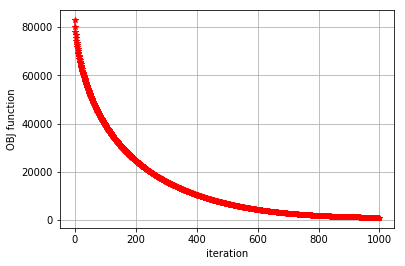

In [101]:
plt.figure
plt.plot(OBJ_plot,'r-*')
plt.xlabel('iteration')
plt.ylabel('OBJ function')
plt.grid()
plt.show()